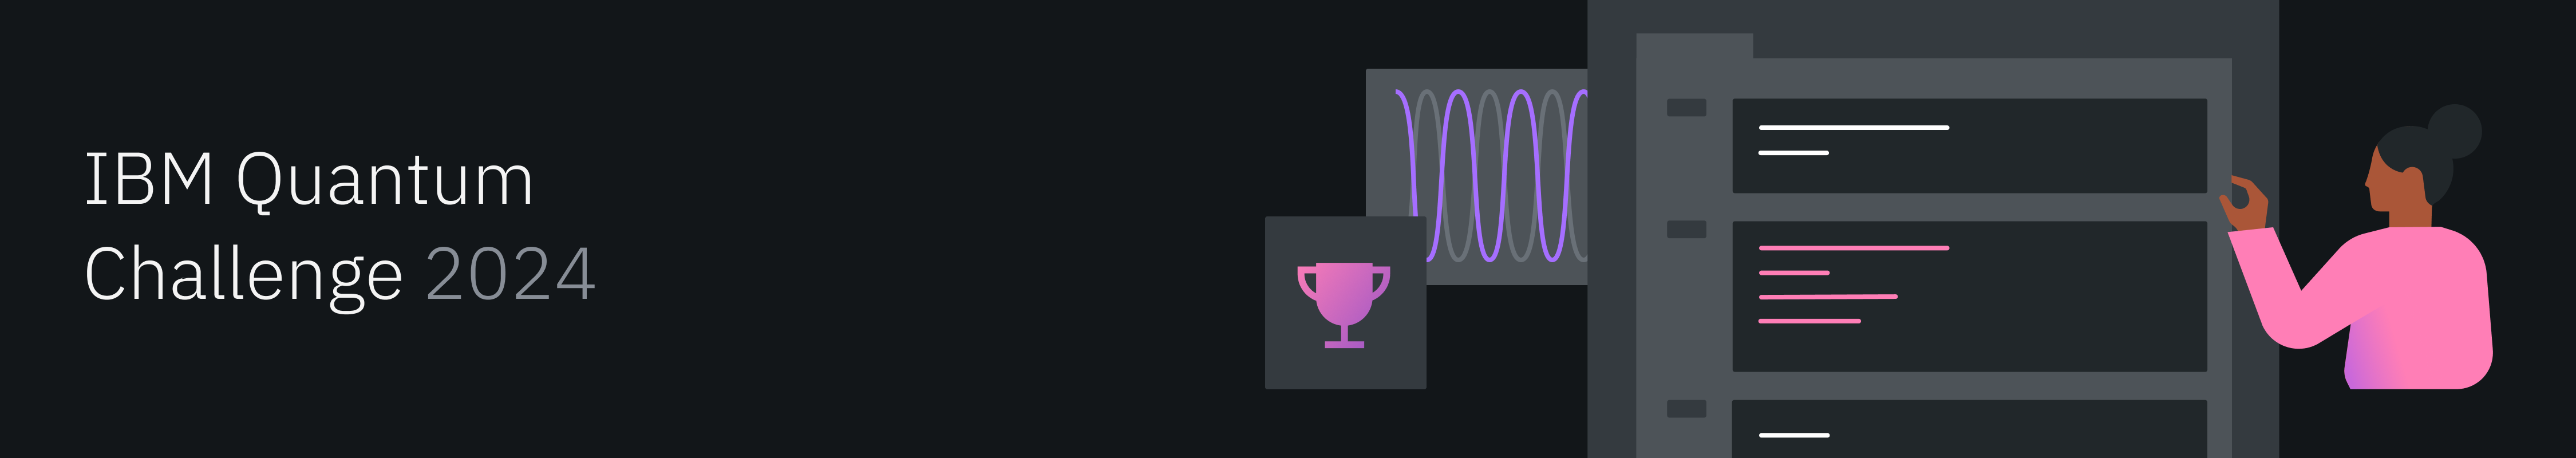

# The Transpiler(2024年 Lab2)



## セットアップ

この lab を適切に実行するには、いくつかのパッケージが必要です。Qiskitと関連するパッケージがまだインストールされていない場合は、コメントを解除してカーネルを再起動した後、以下のセルを実行してください。

In [ ]:
### Install Qiskit and relevant packages, if needed

# !pip install qiskit[visualization]==1.0.2
# !pip install qiskit_ibm_runtime
# !pip install qiskit_aer
# !pip install prototype-zne
# !pip install graphviz

In [1]:
# Load your API token in .env

%load_ext dotenv
%dotenv

では、インポートを実行しましょう。

In [1]:
# Imports

from qiskit.circuit.random import random_circuit
from qiskit.circuit.library import XGate, YGate
from qiskit_ibm_runtime.fake_provider import FakeTorino, FakeOsaka
from qiskit.transpiler import InstructionProperties, PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.preset_passmanagers.plugin import list_stage_plugins
from qiskit.transpiler.timing_constraints import TimingConstraints
from qiskit.transpiler.passes.scheduling import ASAPScheduleAnalysis,PadDynamicalDecoupling
from qiskit.visualization.timeline import draw, IQXStandard
from qiskit.transpiler import StagedPassManager
from qiskit.visualization import plot_circuit_layout
import matplotlib.pyplot as plt
import numpy as np

この lab では Qiskit v1.0.2 を使用する必要があります。始める前に、環境を確認しましょう。

In [2]:
from utils.util_2024_spring_lab2 import version_check

version_check()

You have the right version! Enjoy the challenge!


## プロローグ - トランスパイラーとは？

仮にこんな質問から始めましょう：

誰かがあなたに車のキーを渡し、「私の車に燃料を入れてくれませんか？」と言ったとします。- このとき、あなたはどうすればいいでしょうか？

確かに運転免許証は持ってますが、車種は？シフトレバーはどこにある？コーナーを曲がるためにウィンカーを出したり、到着してから燃料タンクを開けたりするにはどうすればいい？燃料タンクすらない電気自動車だったら？

幸い、人間の脳は賢いので、一連の指示を受け取り、乗り物に適応させることができます。  
これがトランスパイラーなのです。

トランスパイルとは、与えられた入力回路を特定の量子デバイス用の等価回路に書き換えるプロセスで、実際の量子システム上で実行するために、回路を最適化することでもあります。

すべての量子デバイスが同じように動作するわけではないため、この作業が必要になります。あるデバイスに送った命令が、別の量子バックエンドと互換性がないかもしれません。トランスパイルは、デバイスの基本ゲートセット、量子チップのトポロジー、タイミング制約などの観点から動作します。これらについて、この Lab で詳しく説明します。

トランスパイルの目的は、ノイズの多い量子ハードウェアから最高の性能を引き出すことです。ほとんどの回路は、与えられたターゲット・デバイスと互換性を持たせるために一連の変換を受けなければならず、その結果得られる結果に対するノイズの影響を減らすために最適化されます。

**例:** トランスパイルのプロセスは、あなたの命令を含む、単純に見える回路を受け取ることができます：


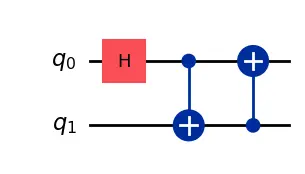

そして、量子コンピューターが受け入れることができる基本ゲートや命令だけを使うことで、望む回路を提供するように変換します。また、ノイズの影響を最小限に抑えるために、回路を最適化します。

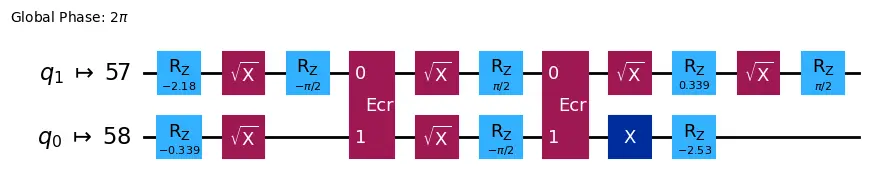

Qiskit SDK の中心的なコンポーネントであるトランスパイラーは、モジュール性と拡張性の観点で設計されています。その主な目的は、新しい回路変換（ transpiler passes と呼ばれる）を記述し、他の既存の pass と組み合わせることで、量子回路の深さと複雑さを大幅に削減することです。どの pass をどの順番で連鎖させるかは、最終的な結果に大きく影響します。このパイプラインは [PassManager](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.PassManager) と [StagedPassManager](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.StagedPassManager) オブジェクトによって決定されます。

`StagedPassManager` は1つ以上の `PassManagers` の実行をオーケストレーションし、それらの実行順序を決定しますが、 `PassManager` オブジェクトは1つ以上の pass のコレクションに過ぎません。 `StagedPassManager` をオーケストラの指揮者、 `PassManagers` を各楽器セクション、 `Pass` オブジェクトを各ミュージシャンと考えてください。

このようにして、ノイズを管理しながらユーティリティスケールの作業を実行できる、ハードウェア効率の高い量子回路を構成することができます。詳細については、IBM Quantum Platform ドキュメントの [Transpile](https://docs.quantum.ibm.com/transpile) セクションをご覧ください。

## 6個のステージ

量子回路をハードウェアの制約に合わせて書き換えたり、性能を最適化したりするのは、簡単なことではありません。Qiskit は標準的な6段階のコンパイルフローと4つのトランスパイルパイプラインを提供します。デフォルトでは、preset pass manager は6つのステージで構成され、各ステージにいくつかのオプションがあります：


- `Init`: このパスでは、回路をシステムに組み込む前に必要な初期 pass を実行します。これには通常、カスタム命令のアンロールと、回路をすべてのシングルおよび2量子ビットゲートに変換することが含まれます。(デフォルトでは、これは回路命令を検証し、マルチ量子ビットゲートをシングルおよび2量子ビットゲートに変換するだけです)。

- `Layout`: このステージではレイアウトを適用し、回路内の仮想量子ビットをバックエンド上の物理量子ビットにマッピングします。

- `Routing`: このステージはレイアウトが適用された後に実行され、元の回路にゲート（すなわち swap ）を注入し、バックエンドの接続性と互換性を持たせます。

- `Translation`: 回路内のゲートをターゲットとなるバックエンドの基本セットに変換します。

- `Optimization`: このステージでは、条件（固定のDepthなど）に達するまでメインの最適化ループを繰り返し実行します。

- `Scheduling`: ハードウェアを意識したスケジューリングを行います。

Qiskit には4つのトランスパイルレベルもあらかじめ用意されており、ユーザーは必要に応じて選択することができます。これらの preset pass managers を変更することができ、さらに入力回路を変換するための完全にカスタムなパイプラインを構築するための pass manager を構築することができます。

トランスパイルによる量子回路の最適化に慣れていない多くのユーザーには、既製のルーチンのいずれかを使用することをお勧めします。しかし、この Lab では、各ステージとその中のオプションについて深---く掘り下げていきます。

#### Exercise1: 各ステージの確認

````{admonition} Exercise
**あなたのタスク:** 各ステージで起こることの説明と、対応するトランスパイルのステージ名を下のコード・セルに当てはめてください。

- **A.** このステージは、いくつかの最適化オプションを使用して、回路操作の数と回路の Depth を減らすことを中心に行われます。
- **B.** このステージは、選択されたレイアウトを使用して回路を実行するために、適切な数の SWAP ゲートを挿入します。
- **C.** このステージは、2つ以上の量子ビットで動作するゲートを、1つまたは2つの量子ビットでのみ動作するゲートに変換するために使用されます。
- **D.** このステージでは、"仮想" 量子ビットから実際の量子デバイスの "物理" 量子ビットへの1対1のマッピングであるゲートシーケンスを実行します。
- **E.** このパスは、ゲート実行間のアイドル時間を考慮し、遅延命令のようなハードウェアを意識した操作を明示的に挿入していると考えることができます。
- **F.** このステージでは、回路で指定されたゲートを、指定されたバックエンドのネイティブの基本ゲートに変換（または展開）します。

ヒント: 答えは常に、引用符付きの大文字1文字となります。例) "A" 

```python
ans = {}

##### Place the correct letter next to the corresponding stage, inside a parenthesis
##### example:  ans["test"] = "M"

ans["init"] =
ans["layout"] =
ans["routing"] =
ans["translation"] =
ans["optimization"] =
ans["scheduling"] =
```
````

In [3]:
ans = {}

# Place the correct letter next to the corresponding stage, inside a parenthesis
# example:  ans["test"] = "M"

ans["init"] = 'C'
ans["layout"] = 'D'
ans["routing"] = 'B'
ans["translation"] = 'F'
ans["optimization"] = 'A'
ans["scheduling"] = 'E'

各トランスパイル・ステージの理解度の確認、お疲れ様でした。次はQiskitの6つのトランスパイル・ステージと `preset_pass_managers` の使い方を見てみましょう。

## Preset pass managers によるトランスパイル

このパートでは、Qiskit の標準的な6つのトランスパイル・ステージの使い方を探ります。 まず、4つの定義済みトランスパイル・パイプラインに焦点を当て、定義済みパイプラインで各パスの機能とオプションを使用する練習を通して、独自の PassManager を構築する方法を見ていきます。

まず、Passmanager と `generate_preset_pass_manager` とは何かを見てみましょう。このパートとそれ以降のパートでは、 [IBM Quantum Platform docs](https://docs.quantum.ibm.com/transpile) とトランスパイルの [API reference documentation](https://docs.quantum.ibm.com/api/qiskit/transpiler) を頻繁に参照しますので、一緒にご覧になることをお勧めします。

### (staged) pass managerとは何ですか？

Pass managerとは、transpiler passes のリストを保存し、回路上で実行することができるオブジェクトです。pass manager は、transpiler passes のリストで[PassManager](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.PassManager) を初期化することで作成できます。回路上でトランスパイルを実行するには、回路を入力として [run](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.PassManager#run) メソッドを呼び出します。

[`StagedPassManager`](https://docs.quantum.ibm.com/transpile/transpiler-stages) クラスで表される staged pass manager は、通常の pass manager よりも抽象度が高い特殊な pass manager です。通常の pass manager が複数の transpiler passes で構成されているのに対し、staged pass manager は複数の pass manager で構成されています。通常、トランスパイルは個別のステージで行われ、各ステージはpass managerによって表されるため、これは有用な抽象化です。

### `Preset Passmanagers`

Preset Passmanagers (`qiskit.transpiler.preset_passmanagers`) には、トランスパイル用の preset pass managers を生成するための関数が含まれています。preset pass managers は StagedPassManager のインスタンスで、事前に定義されたトランスパイル・パイプラインのさまざまな最適化レベルで回路変換を実行するために使用されます。ここでは、 `generate_preset_pass_manager` を使用して pass manager 全体を生成するために使用される関数を紹介します。


```{note} メタファー（比喩）
ここでは用語に惑わされやすいので、オーケストラの指揮者、セクション、個々のミュージシャンについての比喩を思い出してください。

**Bonus Exercise:** `StagedPassManager`、`PassManager`、`pass`の関係について、自分なりのメタファー（比喩）を考えてみてください。

あなたのメタファーを IBM Quantum Challenge Discord の他のメンバーや友人と自由に共有してください。

※以下Author作
![](./resources/2024-spring-lab2-transpiler.png)
```

### `generate_preset_pass_manager`

Qiskit では、`generate_preset_pass_manager` を使用して preset pass manager を素早く生成します。この関数は、各パスの **optimization(最適化)** レベルとオプションを持つスタンドアロンの `PassManager` オブジェクトを構築する便利でシンプルな方法を提供します。次にこれを調べてみましょう。


## 最適化レベル(Optimization levels)

 `generate_preset_pass_manager` 関数には、トランスパイルが回路の最適化に費やす労力を制御する `optimization_level` という位置引数が1つあります。この引数は、0、1、2、3のいずれかの値をとる整数です。

最適化レベルが高いほど、コンパイル時間が長くなる代わりに、より最適化された回路が生成されます。


### Exercise 2: トランスパイルされた回路を「評価」する関数を作る

````{admonition} Exercise
トランスパイルのゴールは回路の実際の実行性能を向上させることなので、あなたのゴールは翻訳された回路の性能を測定する関数を作成することです。この関数は、この Lab の後半で使用します。

**あなたのタスク：**  `scoring` と呼ばれる関数を作成します。この関数は、トランスパイルされた回路、その最終レイアウト( *final layout* )、ターゲットバックエンドを入力として受け取ります。 この関数は回路のスコアを返します。 スコアは0に近いほど良いです。

その他の注意事項：
*  `qiskit-ibm-runtime` パッケージの `FakeTorino` を使用してください。
*  `util.py` の実際の得点計算アルゴリズムは[Mapomatic](https://github.com/qiskit-community/mapomatic) のもので、メインコードは PrimitiveV2 に合わせて更新されています。
* 私たちはこの関数の一部をあなたのために構築しました。
* トランスパイルされた回路の最終的なレイアウトを得る必要があります。この2つのページを参考に、以下のコードを完成させてください。
  * [QuantumCircuit APIドキュメントのレイアウトセクション](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.QuantumCircuit#layout)
  * [Qiskit Transpiler APIドキュメントのTranspileLayoutセクション](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.TranspileLayout)

```python
##### Create the scoring function

def scoring( qc, backend):
    from util import transpile_scoring

    layout = ##your code here
    fidelity = transpile_scoring(qc, layout, backend)
    score = ##your code here

    return score

```
````

In [10]:
### Create the scoring function

def scoring( qc, backend):
    from utils.util_2024_spring_lab2 import transpile_scoring

    layout =  qc.layout #fill this part
    fidelity = transpile_scoring(qc, layout, backend)
    score = 1 - fidelity #fill this part

    return score

```{toggle}
fidelity（忠実度）とは量子状態の正確性・再現性を評価する指標で、0から1の範囲で理想的な量子状態と実際の量子状態間の類似度を測定します。  
fidelityは1に近いほど理想的な状態に近いことを意味するため、今回定義するスコアリング関数は0に近いほど回路の実行性能が高いことを意味するので、`1-fidelity`でスコアを定義しています。
```

これでトランスパイルされた回路の性能を測定する関数ができました。 次のパートに進む前に、モックバックエンド (fake backend) で回路を正しくテストするために必要なすべての設定を終わらせましょう。

つまり、circuit と fake backend です！

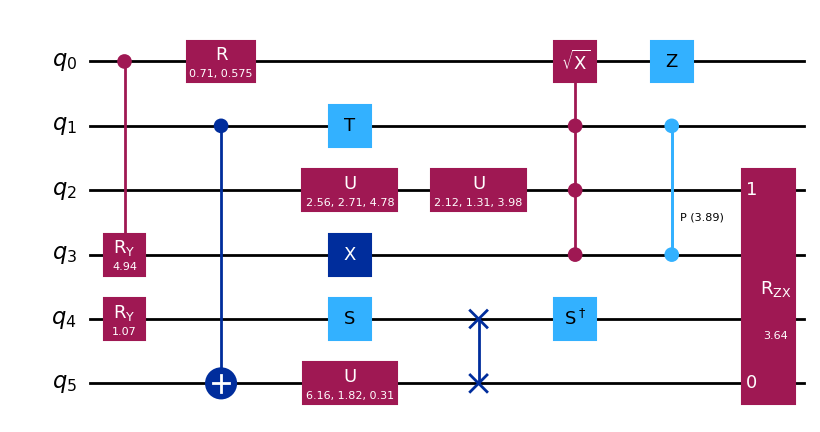

In [5]:
### Create a random circuit

## DO NOT CHANGE THE SEED NUMBER
seed = 10000

## Create circuit

num_qubits = 6
depth = 4
qc = random_circuit(num_qubits,depth,measure=False, seed=seed)

qc.draw('mpl')

各最適化レベルの性能をテストするには、 `FakeTorino` を呼び出し、 `backend` として保存します。

`FakeTorino` は、Heronプロセッサーを搭載した最新のIBM Quantumバックエンドである ibm_torino の接続性とノイズ機能を備えています。


In [6]:
## Save FakeTorino as backend

backend = FakeTorino()

4つの最適化レベルをすべて実行し、最後に結果を比較します。そのために、作業中に情報を保持するための配列をいくつか作成し、後でそれを使用します。

次のコードセルでは、単にこれらの配列を作成します。とりあえず実行して先に進んでください。

In [7]:
circuit_depths = {
    'opt_lv_0': None,
    'opt_lv_1': None,
    'opt_lv_2': None,
    'opt_lv_3': None,
}
gate_counts = {
    'opt_lv_0': None,
    'opt_lv_1': None,
    'opt_lv_2': None,
    'opt_lv_3': None,
}

scores = {
    'opt_lv_0': None,
    'opt_lv_1': None,
    'opt_lv_2': None,
    'opt_lv_3': None,
}

### Optimization level = 0

```{note}
これらの4つのセクションのどこかで、手助けや説明が必要な場合は、 <a href="https://docs.quantum.ibm.com/transpile/set-optimization">このドキュメント</a> を参照して、 `optimization_level` をよりよく理解してください。
```

Optimization level 0 は、 **デバイスの特性評価実験** を目的としており、最適化を実行することなく、入力回路をターゲットバックエンドの制約にマッピングするだけです。[TrivialLayout](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.TrivialLayout#triviallayout) でレイアウト/ルーティングを行い、仮想と同じ物理量子ビット数を選択し、[StochasticSwap](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.StochasticSwap#stochasticswap) でSWAPを挿入して動作させます。

FakeTorino バックエンドを使って optimization level = 0 の pass manager を作り、その結果を見てみましょう。


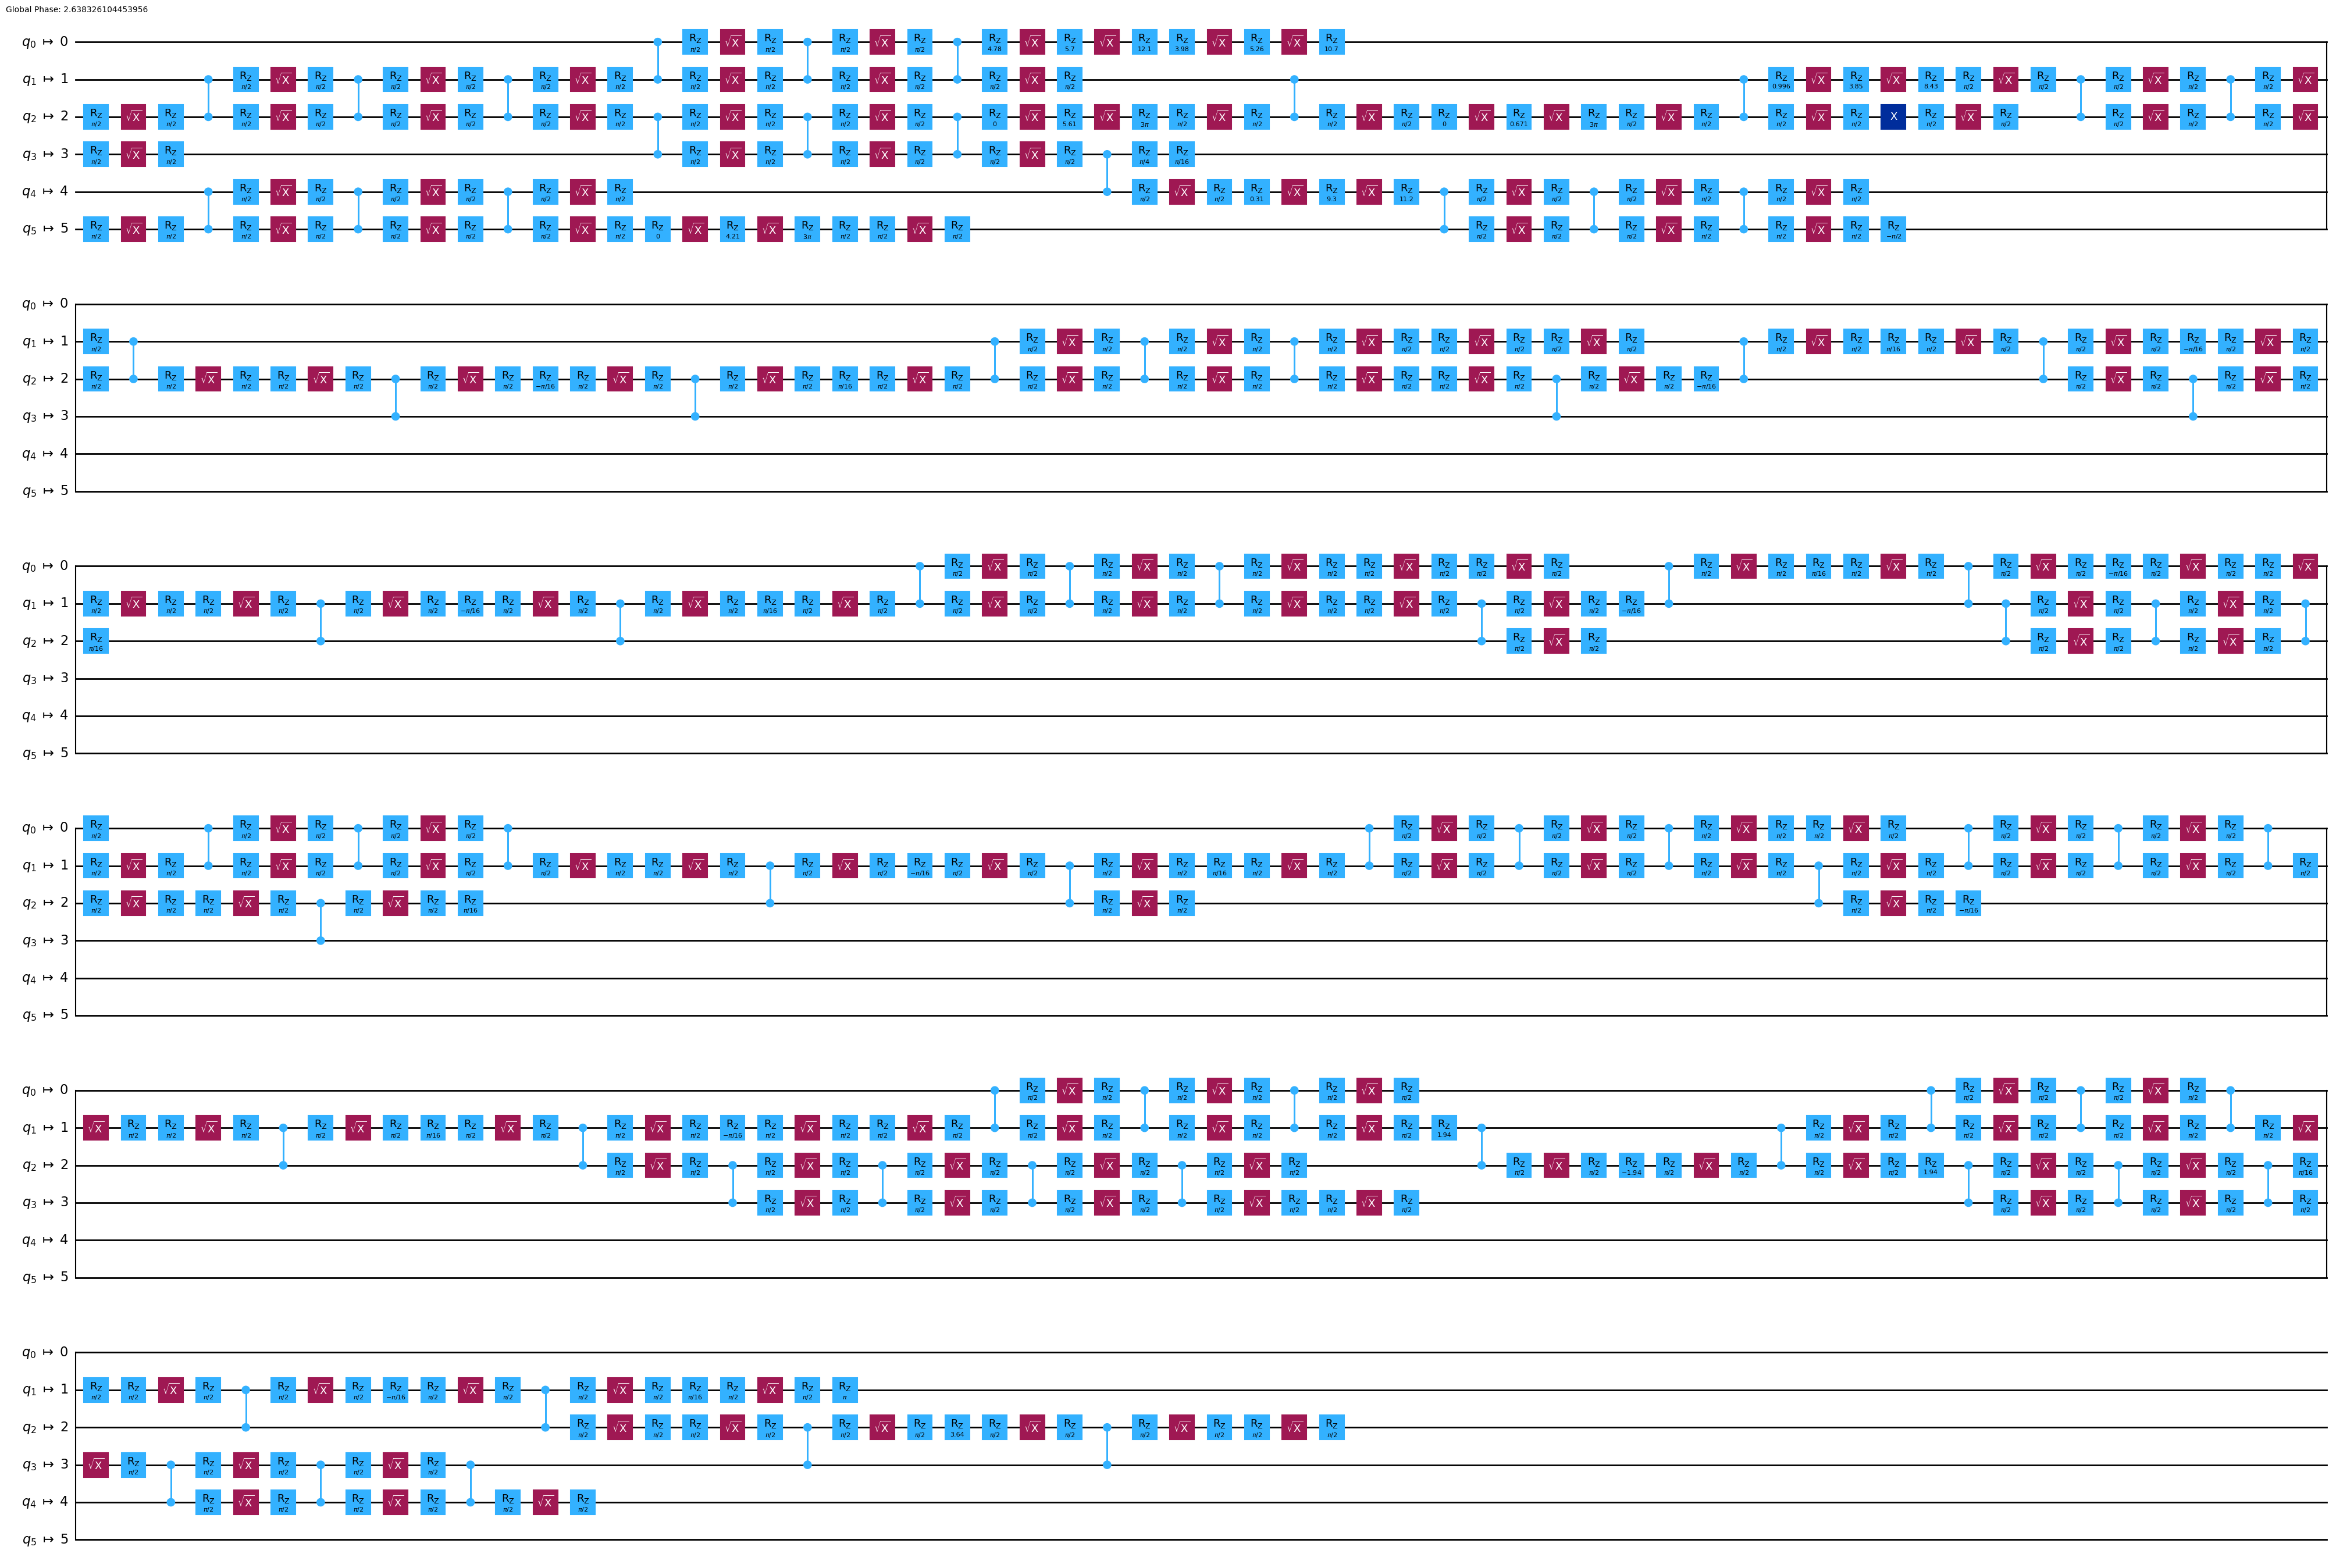

In [8]:
# Make a pass manager with our desired optimization level and backend
pm_lv0 = generate_preset_pass_manager(backend=backend, optimization_level=0, seed_transpiler=seed)

# Run for our random circuit
tr_lv0 = pm_lv0.run(qc)

# uncomment the next line to draw circuit
tr_lv0.draw('mpl', idle_wires=False, fold=60)

前述したように、`optimization_level=0`は、バックエンドの基底ゲートを用いて基本的なゲート分解を行い、論理量子ビットを物理量子ビットに同じ数の順序でマッピングします。論理量子ビット0を物理量子ビット0にマッピングし、論理量子ビット1を物理量子ビット1にマッピングします。


#### Exercise3:  回路の性能検証

````{admonition} Exercise: スタート
**あなたのタスク：** ランダム回路の回路の Depth (深さ)、総ゲート数の合計を求め、 `scoring` を用いてこの回路の性能スコアを計算してください。 与えられたコードを使用して、これらの結果をそれぞれ先に作成した配列に保存します。

```python
##### Your code here #####

circuit_depths['opt_lv_0'] =
gate_counts['opt_lv_0'] =
scores['opt_lv_0'] =

##### Don't change code after this line #####

print("Optimization level 0 results")
print("====================")
print("Circuit depth:", circuit_depths['opt_lv_0'])
print("Gate count:", gate_counts['opt_lv_0'])
print("Score:", scores['opt_lv_0'])
```
````

```{hint}
- `circuit_depths` について： [IBM Documentation](https://docs.quantum.ibm.com/api/qiskit/0.42/circuit)
-  `gate_counts`について： [stackexchangeのディスカッションが参考になるかもしれません。](https://quantumcomputing.stackexchange.com/questions/25931/qiskit-count-of-each-gates)
-  `scores` について： 以前に作成した `scoring` 関数を使用してください。
```

In [11]:
### Your code here ###

circuit_depths['opt_lv_0'] = tr_lv0.depth()
gate_counts['opt_lv_0'] = tr_lv0.size()
scores['opt_lv_0'] = scoring(tr_lv0, backend)

### Don't change code after this line ###

print("Optimization level 0 results")
print("====================")
print("Circuit depth:", circuit_depths['opt_lv_0'])
print("Gate count:", gate_counts['opt_lv_0'])
print("Score:", scores['opt_lv_0'])

Optimization level 0 results
Circuit depth: 334
Gate count: 659
Score: 0.378009145088254


### Optimization level = 1

Optimization level 1 は、 **軽い最適化** を行います。その意味は以下の通りです：

- レイアウト/ルーティング: レイアウトはまず [TrivialLayout](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.TrivialLayout#triviallayout) で試みられます。 追加のSWAPが必要な場合は、 [SabreSWAP](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.SabreSwap#sabreswap) を使用して最小数のSWAPを持つレイアウトを見つけ、 [VF2LayoutPostLayout](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.VF2PostLayout) を使用してグラフ内の最適な量子ビットを選択しようとします。
- [InverseCancellation](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.InverseCancellation#inversecancellation)
- [1Qゲート最適化](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.Optimize1qGates#optimize1qgates)

今度は自分で pass manager を作ってみましょう。再度、 `generate_preset_pass_manager` で FakeTorino バックエンドを使用してください。また、 `optimization_level` を1に設定し、 `seed_transpiler` = `seed` に設定してください。

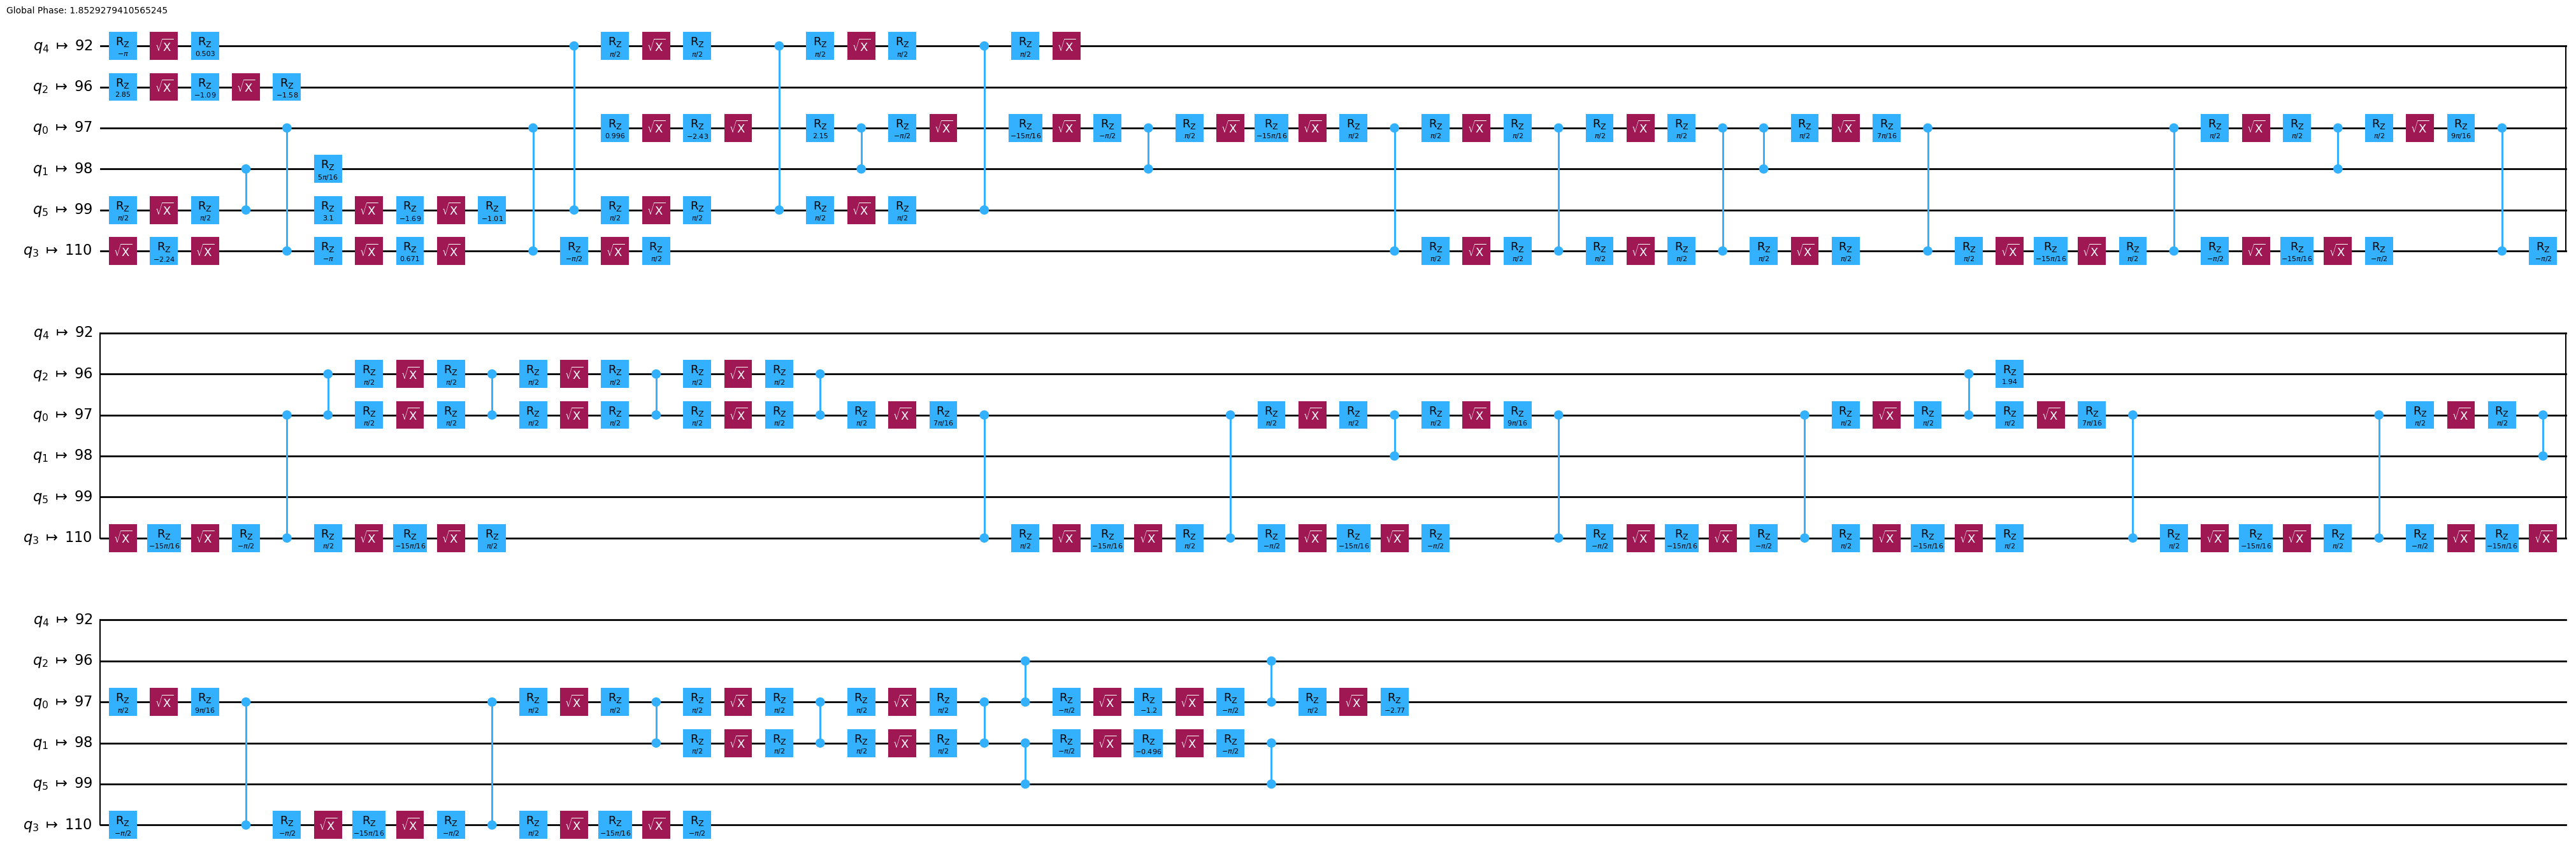

In [12]:
# Make a pass manager with our desired optimization level and backend
pm_lv1 = generate_preset_pass_manager(backend=backend, optimization_level=1, seed_transpiler=seed) ### your code here ###

# Run for our random circuit
tr_lv1 = pm_lv1.run(qc)

# uncomment the next line to draw circuit
tr_lv1.draw('mpl', idle_wires=False, fold=60)

論理量子ビットが異なる物理量子ビットセットにマッピングされ、ゲート数が少なくなっているのがわかるはずです。 前回と同じように、もう一度ランダム回路の回路Depth、総ゲート数の合計を求め、 `scoring` を使ってこの回路の性能スコアを計算してみましょう。

In [23]:
### Your code here ###

circuit_depths['opt_lv_1'] = tr_lv1.depth()
gate_counts['opt_lv_1'] = tr_lv1.size()
scores['opt_lv_1'] = scoring(tr_lv1, backend)

### Don't change code after this line ###

print("Optimization level 1 results")
print("====================")
print("Circuit depth:", circuit_depths['opt_lv_1'])
print("Gate count:", gate_counts['opt_lv_1'])
print("Score:", scores['opt_lv_1'])

Optimization level 1 results
Circuit depth: 147
Gate count: 247
Score: 0.10053438782707702


### Optimization level = 2

Optimization level 2は、 **中程度の最適化** を行います：

- レイアウト/ルーティング： Optimization level 1（[TrivialLayout](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.TrivialLayout#triviallayout)なし）＋より深く探索したDepthと最適化関数の試行を増やしたヒューリスティック最適化。[TrivialLayout](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.TrivialLayout#triviallayout) が使用されていないため、同じ物理量子ビット数と仮想量子ビット数を使用する試みはありません。
- [CommutativeCancellation](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.CommutativeCancellation#commutativecancellation)

今回もFakeTorinoバックエンドで `generate_preset_pass_manager` を使用し、 `seed_transpiler` = `seed` を使用して、 `optimization_level` が 2 の pass manager を作ってみましょう。

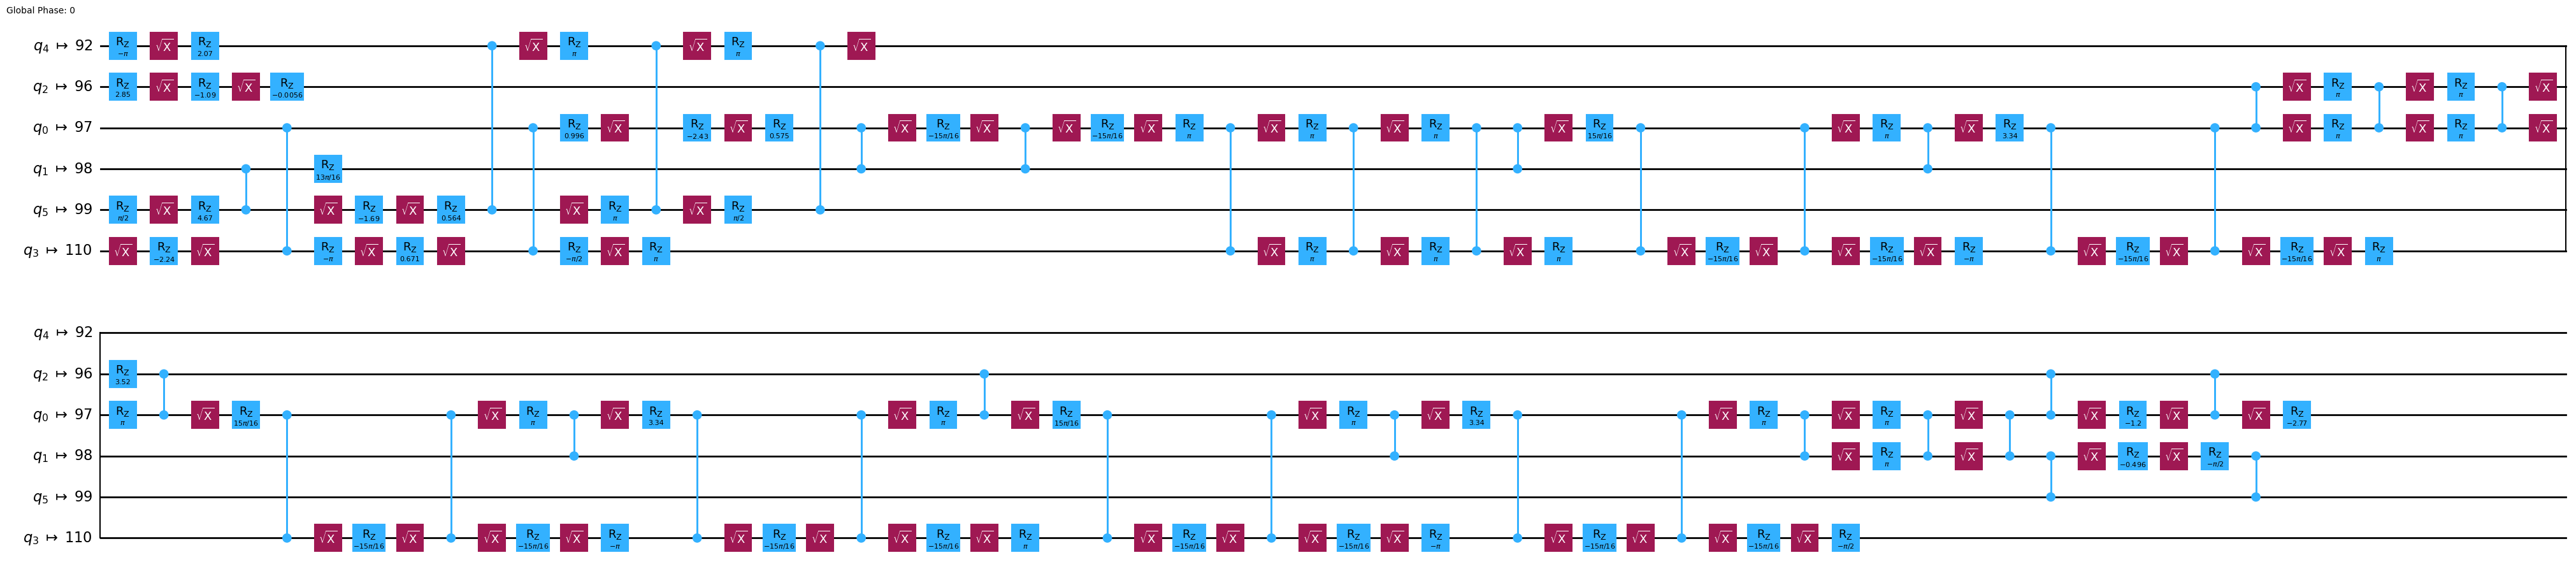

In [14]:
# Make a pass manager with our desired optimization level and backend
pm_lv2 = generate_preset_pass_manager(backend=backend, optimization_level=2, seed_transpiler=seed) ### your code here ###

# Run for our random circuit
tr_lv2 = pm_lv2.run(qc)

# uncomment the next line to draw circuit
tr_lv2.draw('mpl', idle_wires=False, fold=60)

一見しただけでも、ゲートの数がかなり減っていることがわかります。 論理量子ビットがマッピングされる物理量子ビットに変化はありません。では、トランスパイルの性能を測定してみましょう。上と同じコードです。

In [15]:
### Your code here ###

circuit_depths['opt_lv_2'] = tr_lv2.depth()
gate_counts['opt_lv_2'] = tr_lv2.size()
scores['opt_lv_2'] = scoring(tr_lv2, backend)

### Don't change code after this line ###

print("Optimization level 2 results")
print("====================")
print("Circuit depth:", circuit_depths['opt_lv_2'])
print("Gate count:", gate_counts['opt_lv_2'])
print("Score:", scores['opt_lv_2'])

Optimization level 2 results
Circuit depth: 110
Gate count: 187
Score: 0.10053438782707702


### Optimization level = 3

Optimization level 3 は **高度な最適化** を行います:

- Optimization level 2 ＋ ヒューリスティックは、より大きな努力/試行で、レイアウト/ルーティングをさらに最適化したヒューリスティック最適化
- [CartanのKAK分解](https://arxiv.org/abs/quant-ph/0507171) を用いた2量子ビットブロックの再合成。
- ユニタリー破りのパス：
    - `OptimizeSwapBeforeMeasure`: SWAPを回避するために、measure 命令の古典ビットを再ターゲットすることで、測定前のSWAPを除去。
    - `RemoveDiagonalGatesBeforeMeasure`: 測定の前に対角ゲート（RZ、T、Zなど）を取り除く。対角2Qゲートを含む。

次に何をすべきか分かりますね！

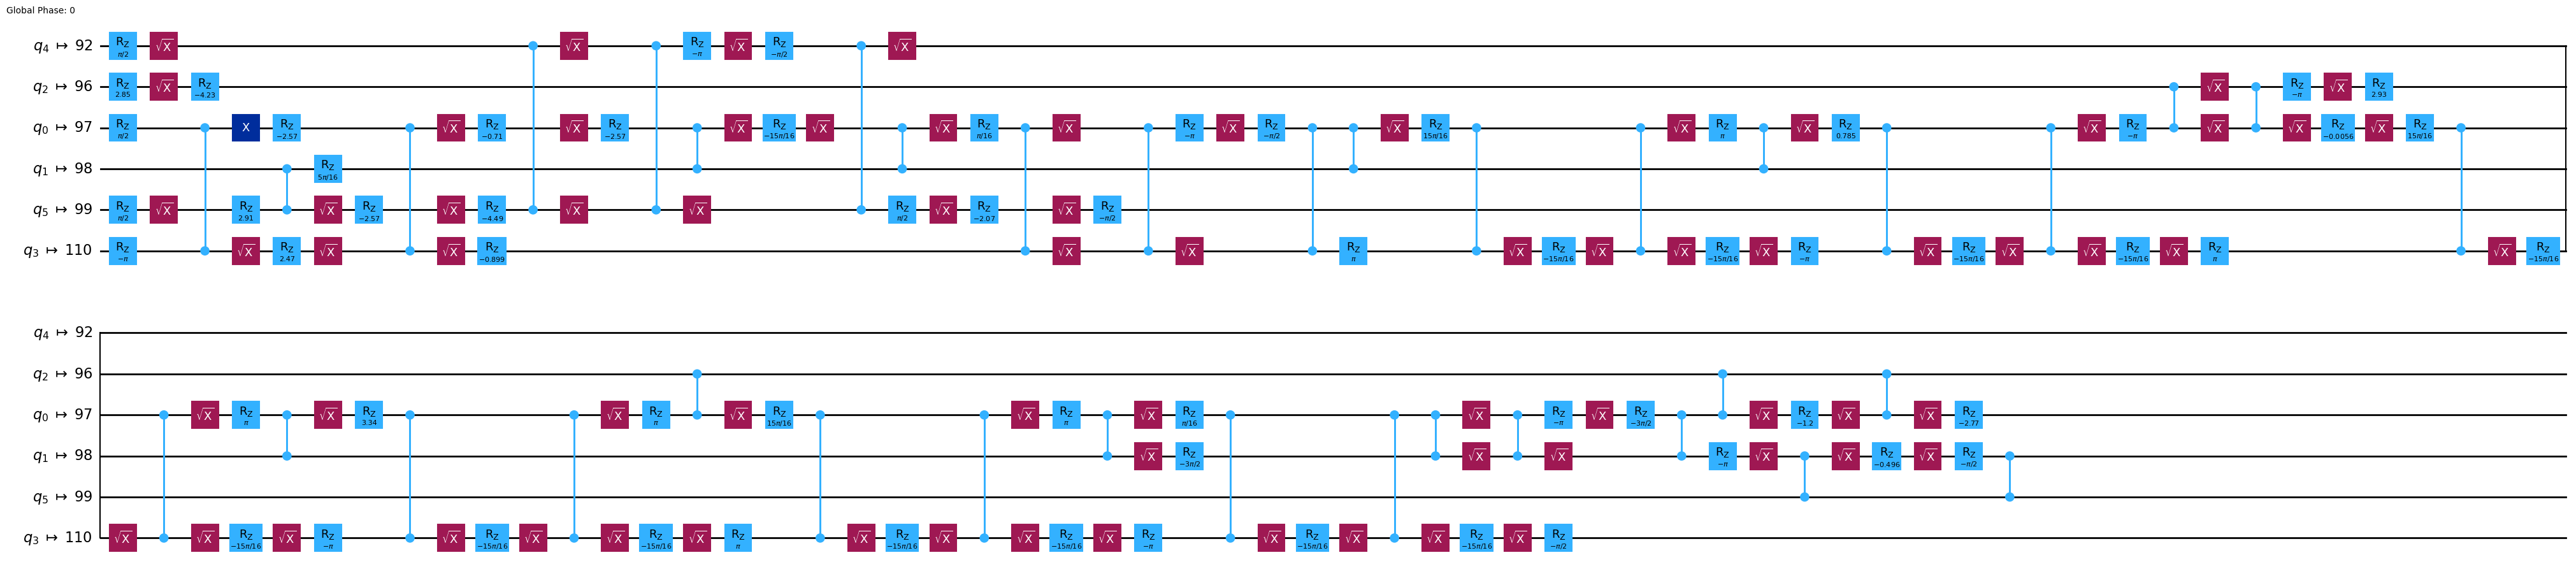

In [16]:
pm_lv3 = generate_preset_pass_manager(backend=backend, optimization_level=3, seed_transpiler=seed) ### your code here ###

tr_lv3 = pm_lv3.run(qc) ### your code here ###

# uncomment to draw circuit
tr_lv3.draw('mpl', idle_wires=False, fold=60)

驚きました！これでゲートの数が少なくなりましたね！どうなったかみてみましょう。。。

In [17]:
### Your code here ###

circuit_depths['opt_lv_3'] = tr_lv3.depth()
gate_counts['opt_lv_3'] = tr_lv3.size()
scores['opt_lv_3'] = scoring(tr_lv3, backend)


### Don't change code after this line ###

print("Optimization level 3 results")
print("====================")
print("Circuit depth:", circuit_depths['opt_lv_3'])
print("Gate count:", gate_counts['opt_lv_3'])
print("Score:", scores['opt_lv_3'])

Optimization level 3 results
Circuit depth: 101
Gate count: 177
Score: 0.09612632219732442


すべての結果が出揃ったので、各最適化レベルに応じて、回路のDepth、ゲート数、評価スコアがどれだけ変化したかをグラフにしてみましょう。

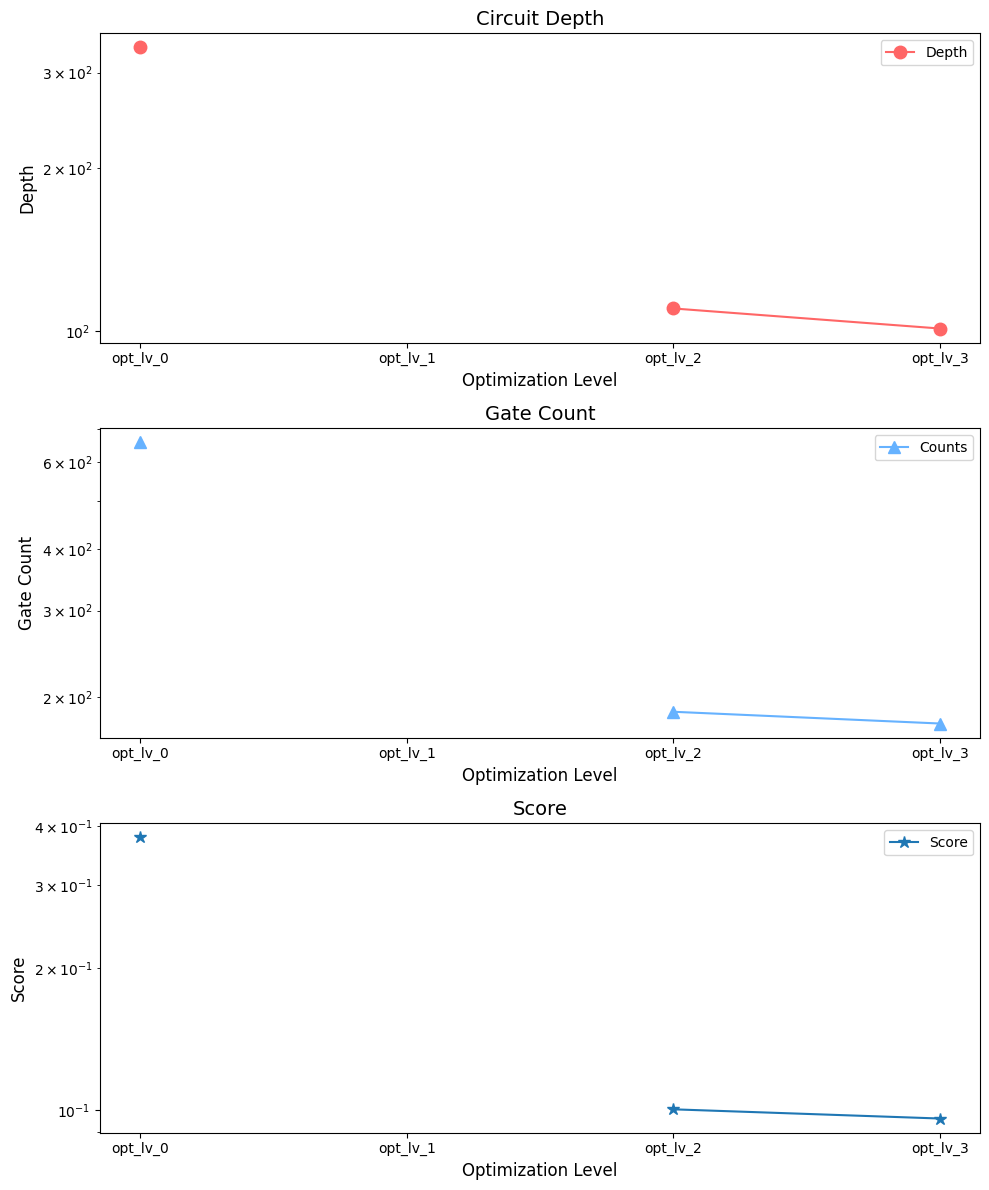

In [18]:
colors = ['#FF6666', '#66B2FF']
ax = ["opt_lv_0", "opt_lv_1", "opt_lv_2", "opt_lv_3"]
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

# Plot 1: Circuit Depth
ax1.semilogy(ax, [circuit_depths[key] for key in ax],'o-',markersize=9, color='#FF6666', label="Depth")
ax1.set_xlabel("Optimization Level", fontsize=12)
ax1.set_ylabel("Depth", fontsize=12)
ax1.set_title("Circuit Depth", fontsize=14)
ax1.legend(fontsize=10)

# Plot 2: Total Number of Gates
ax2.semilogy(ax, [gate_counts[key] for key in ax],'^-',markersize=9, color='#66B2FF', label="Counts")
ax2.set_xlabel("Optimization Level", fontsize=12)
ax2.set_ylabel("Gate Count", fontsize=12)
ax2.set_title("Gate Count", fontsize=14)
ax2.legend(fontsize=10)

# Plot 3: Score of Transpiled Circuit
ax3.semilogy(ax, [scores[key] for key in ax],'*-',markersize=9, label="Score")
ax3.set_xlabel("Optimization Level", fontsize=12)
ax3.set_ylabel("Score", fontsize=12)
ax3.set_title("Score", fontsize=14)
ax3.legend(fontsize=10)

fig.tight_layout()
plt.show()

````{admonition} Exercise: 終了
上記であなたは、さまざまな pass managers を構築し、テストし、それぞれの情報を対応する配列に保存するために多大な労力を費やしました。 その情報をグラフ化し、結果を目に見える形で比較しました。
````

## オプション付きトランスパイルのステージの詳細

これまで、Qiskit が提供する4つの定義済み transpiler pipeline をランダム回路を使って見てきました。  
Qiskit SDK v1.0 transpiler の主な特徴の1つは、custom passmanager を簡単に構築・設定できることです。 上述した最適化レベルとともに6つの標準 pass を使用するだけでなく、各 pass のオプションやプラグインを好きなように選択することで、独自の pass manager を構成できます。

もう一つの方法は、`StagedPassManager` を使用することで、必要な数の pass で pass manager を作成することです。さらに、新しい pass manager を作成してデプロイし、Qiskitに [plugin](https://docs.quantum.ibm.com/transpile/create-a-transpiler-plugin) の形で実装して他のユーザーが使用できるようにすることもできます。

次のセクションで3つの方法すべてを見てみましょう。まず最も簡単な方法から始めます。

### Custom passmanagerの構築

#### Init ステージ

この最初のステージは、デフォルトではほとんど何もせず、独自の初期最適化を含めたい場合に主に有用です。 ほとんどのレイアウトとルーティングアルゴリズムは、1量子ビットと2量子ビットのゲートでしか動作しないように設計されているため、このステージは、2量子ビット以上で動作するゲートを、1量子ビットか2量子ビットでのみ動作するゲートに変換するためにも使用されます。

このステージで、使用したい量子ビットの引数を指定すると、その値は、それを変更するすべてのパスを上書きします。詳しくは、 [Default settings and configuration options documentation](https://docs.quantum.ibm.com/transpile/defaults-and-configuration-options)を参照してください。

まず、init ステージで使用可能なオプションを確認してみましょう。


In [19]:
list_stage_plugins("init")

['default']

追加のプラグインがなければ、デフォルトのオプションしか存在しません。 このプロセスには、 `optimization_level`に応じていくつかのトラtranspiler pass plugins が含まれています。

そのために、`init_method="default"` オプションを持つパス・マネージャーを作成しましょう。


In [20]:
print("Plugins run by default init stage")
print("=================================")

for i in range(4):
    print(f"\nOptimization level {i}:")
    pm = generate_preset_pass_manager(backend=backend, optimization_level=i, init_method="default", seed_transpiler=1000)
    for task in pm.init.to_flow_controller().tasks:
        print(" -", type(task).__name__)

Plugins run by default init stage

Optimization level 0:
 - UnitarySynthesis
 - HighLevelSynthesis
 - BasisTranslator

Optimization level 1:
 - UnitarySynthesis
 - HighLevelSynthesis
 - BasisTranslator
 - InverseCancellation

Optimization level 2:
 - UnitarySynthesis
 - HighLevelSynthesis
 - BasisTranslator
 - InverseCancellation

Optimization level 3:
 - UnitarySynthesis
 - HighLevelSynthesis
 - BasisTranslator
 - OptimizeSwapBeforeMeasure
 - RemoveDiagonalGatesBeforeMeasure
 - InverseCancellation


各プラグインのAPIドキュメントの表です。各プラグインについて、より深く知りたい場合はご覧ください。

| Plugin | Description | API docs link|
|---- | ---- | ------|
|UnitarySynthesis| Synthesize unitaries over some basis gates | https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.UnitarySynthesis#unitarysynthesis |
|HighLevelSynthesis |Synthesize higher-level objects and unroll custom definitions| https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.HighLevelSynthesis#highlevelsynthesis |
| BasisTranslator | Translates gates to a target basis by searching for a set of translations from a given EquivalenceLibrary | https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.BasisTranslator#basistranslator |
| InverseCancellation| Cancel specific gates which are inverses of each other when they occur back-to- back | https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.InverseCancellation#inversecancellation |
| OptimizeSwapBeforeMeasure | Moves the measurements around to avoid SWAPs | NA |
| RemoveDiagonalGatesBeforeMeasure | Remove diagonal gates (including diagonal 2Q gates) before a measurement | https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.RemoveDiagonalGatesBeforeMeasure |


#### Layout ステージ

次のステージは、回路が送られるバックエンドのレイアウトや接続性が含まれます。 一般に、量子回路は抽象的なエンティティであり、その量子ビットは計算で使用される実際の量子ビットを「仮想的」または「論理的」に表現したものです。 ゲートのシーケンスを実行するためには、「仮想」量子ビットから実際の量子デバイスの「物理」量子ビットへの1対1のマッピングが必要です。 このマッピングは Layout オブジェクトとして保存され、ISA (Instruction set architecture) で定義された制約の一部となります。

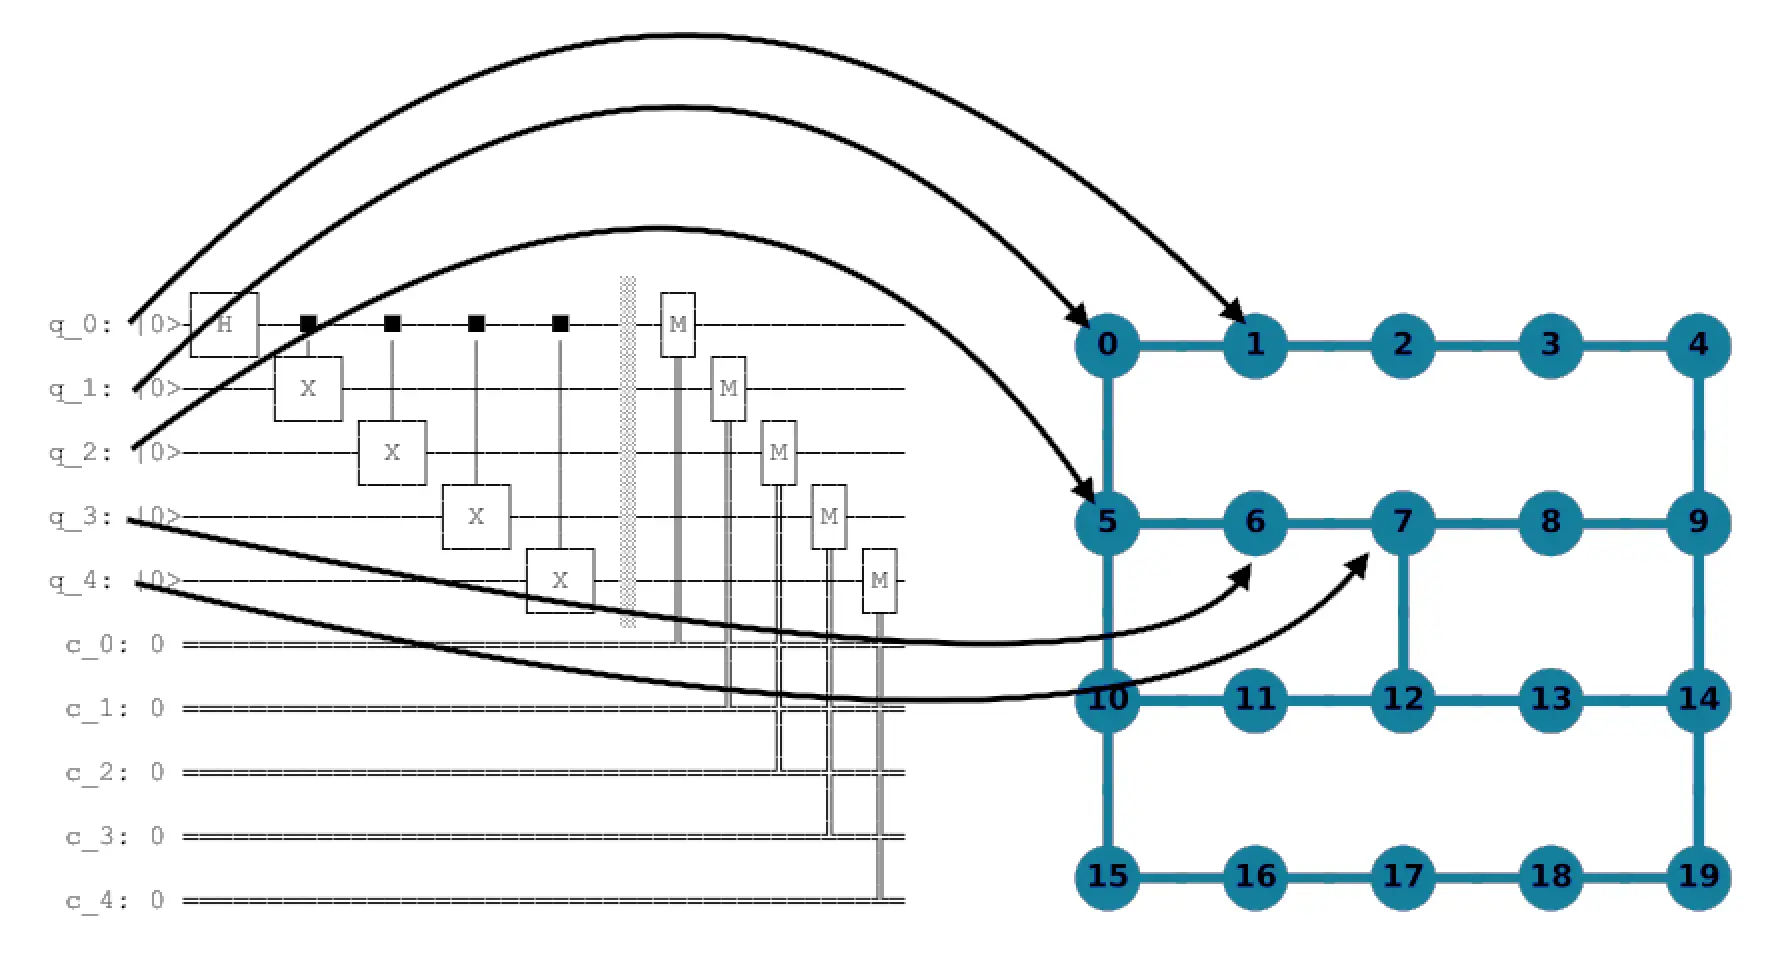

マッピングの選択は、入力回路をデバイスのトポロジーにマッピングするために必要なSWAP演算の回数を最小化し、最もよく較正された量子ビットが使用されるようにするために非常に重要です。 このステージの重要性から、 preset pass managers は最適なレイアウトを見つけるためにいくつかの異なる方法を試します。

まず、"完璧な" レイアウト (SWAP演算が必要ないレイアウト) を見つけようとします。次に、完璧なレイアウトが見つからない場合に使用する、最適なレイアウトを見つけるヒューリスティックなパスです。

最初のステップ（完璧なレイアウトの探索）では、通常2つの Pass が使用されます：

- [TrivialLayout](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.TrivialLayout#triviallayout)：各仮想量子ビットをデバイス上の同じ番号の物理量子ビットにとにかくマッピングします（すなわち、[0,1,1,3] -> [0,1,1,3]）。これは optimzation_level=1 においてのみ使用される歴史的な動作で、完璧なレイアウトを見つけようとするものです。失敗した場合は、次にVF2Layoutが試されます。
- [VF2Layout](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.VF2Layout)：これは、このステージをVF2++アルゴリズムによって解決される部分グラフ同型問題として扱うことによって、理想的なレイアウトを選択する AnalysisPass です。 複数のレイアウトが見つかった場合、scoring heuristic が実行され、最も平均誤差の少ないマッピングが選択されます。

そして、ヒューリスティック・ステージでは、通常2つの Pass が使用されます：

- [DenseLayout](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.DenseLayout)：最も接続性が高く、回路と同じ数の量子ビットを持つデバイスの部分グラフを見つけます (回路内に制御フロー演算 (IfElseOp など) が存在する場合、optimization level 1 に使用されます)。
- [SabreLayout](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.SabreLayout)：このpassは、初期ランダムレイアウトから開始し、SabreSwapアルゴリズムを繰り返し実行することによってレイアウトを選択します。 このpassは、optimization levels 1, 2, 3 で、VF2Layout pass で完璧なレイアウトが見つからなかった場合にのみ使用されます。 このアルゴリズムの詳細については、論文 [arXiv:1809.02573](arXiv:1809.02573) を参照してください。

initステージと同じコードを使用することで、これら4つのpassを見つけることができます。

In [21]:
list_stage_plugins("layout")

['default', 'dense', 'sabre', 'trivial']

まず、以下のコードを実行して、 `layout_method='default'` オプションで、どのタスクがどの optimization_level で有効になるかをチェックしてみましょう。

Plugins run by default layout stage

Optimization level 0:
 -  TrivialLayout
[1, 4, 2, 0, 5, 3]


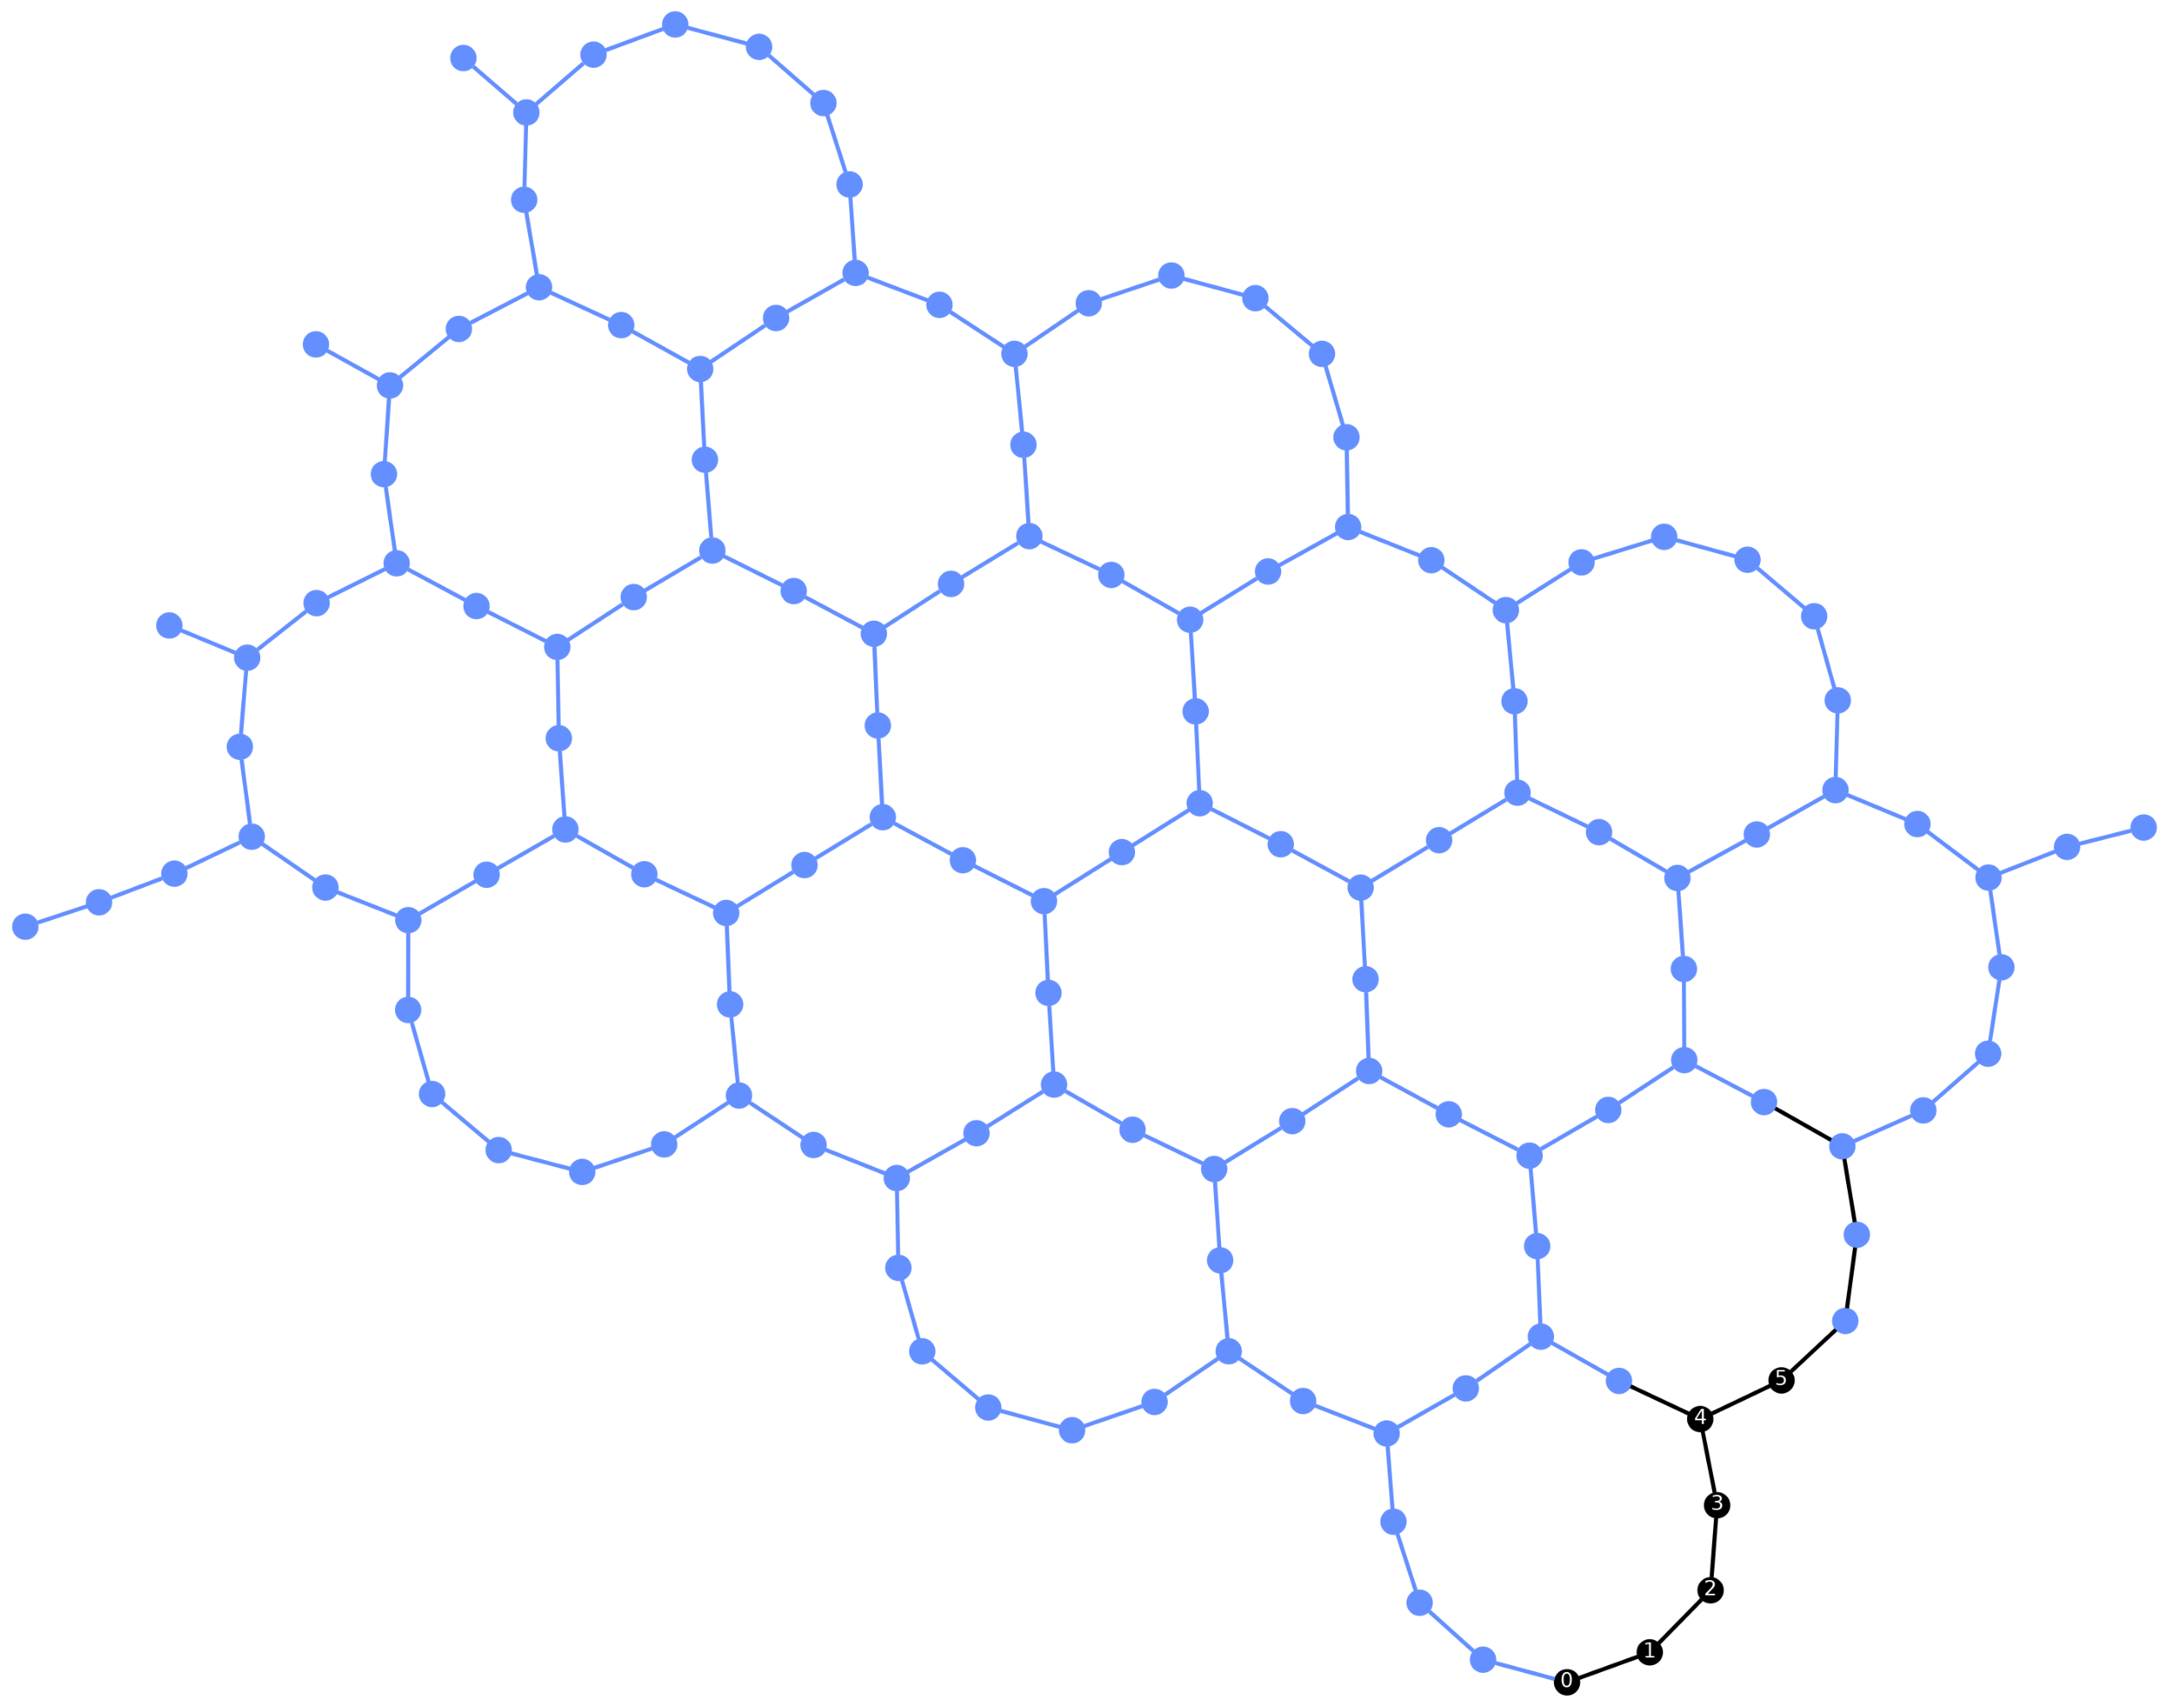


Optimization level 1:
 -  TrivialLayout
 -  CheckMap
 -  VF2Layout
 -  BarrierBeforeFinalMeasurements
 -  SabreLayout
 -  FlowControllerLinear
[85, 84, 83, 93, 73, 82]


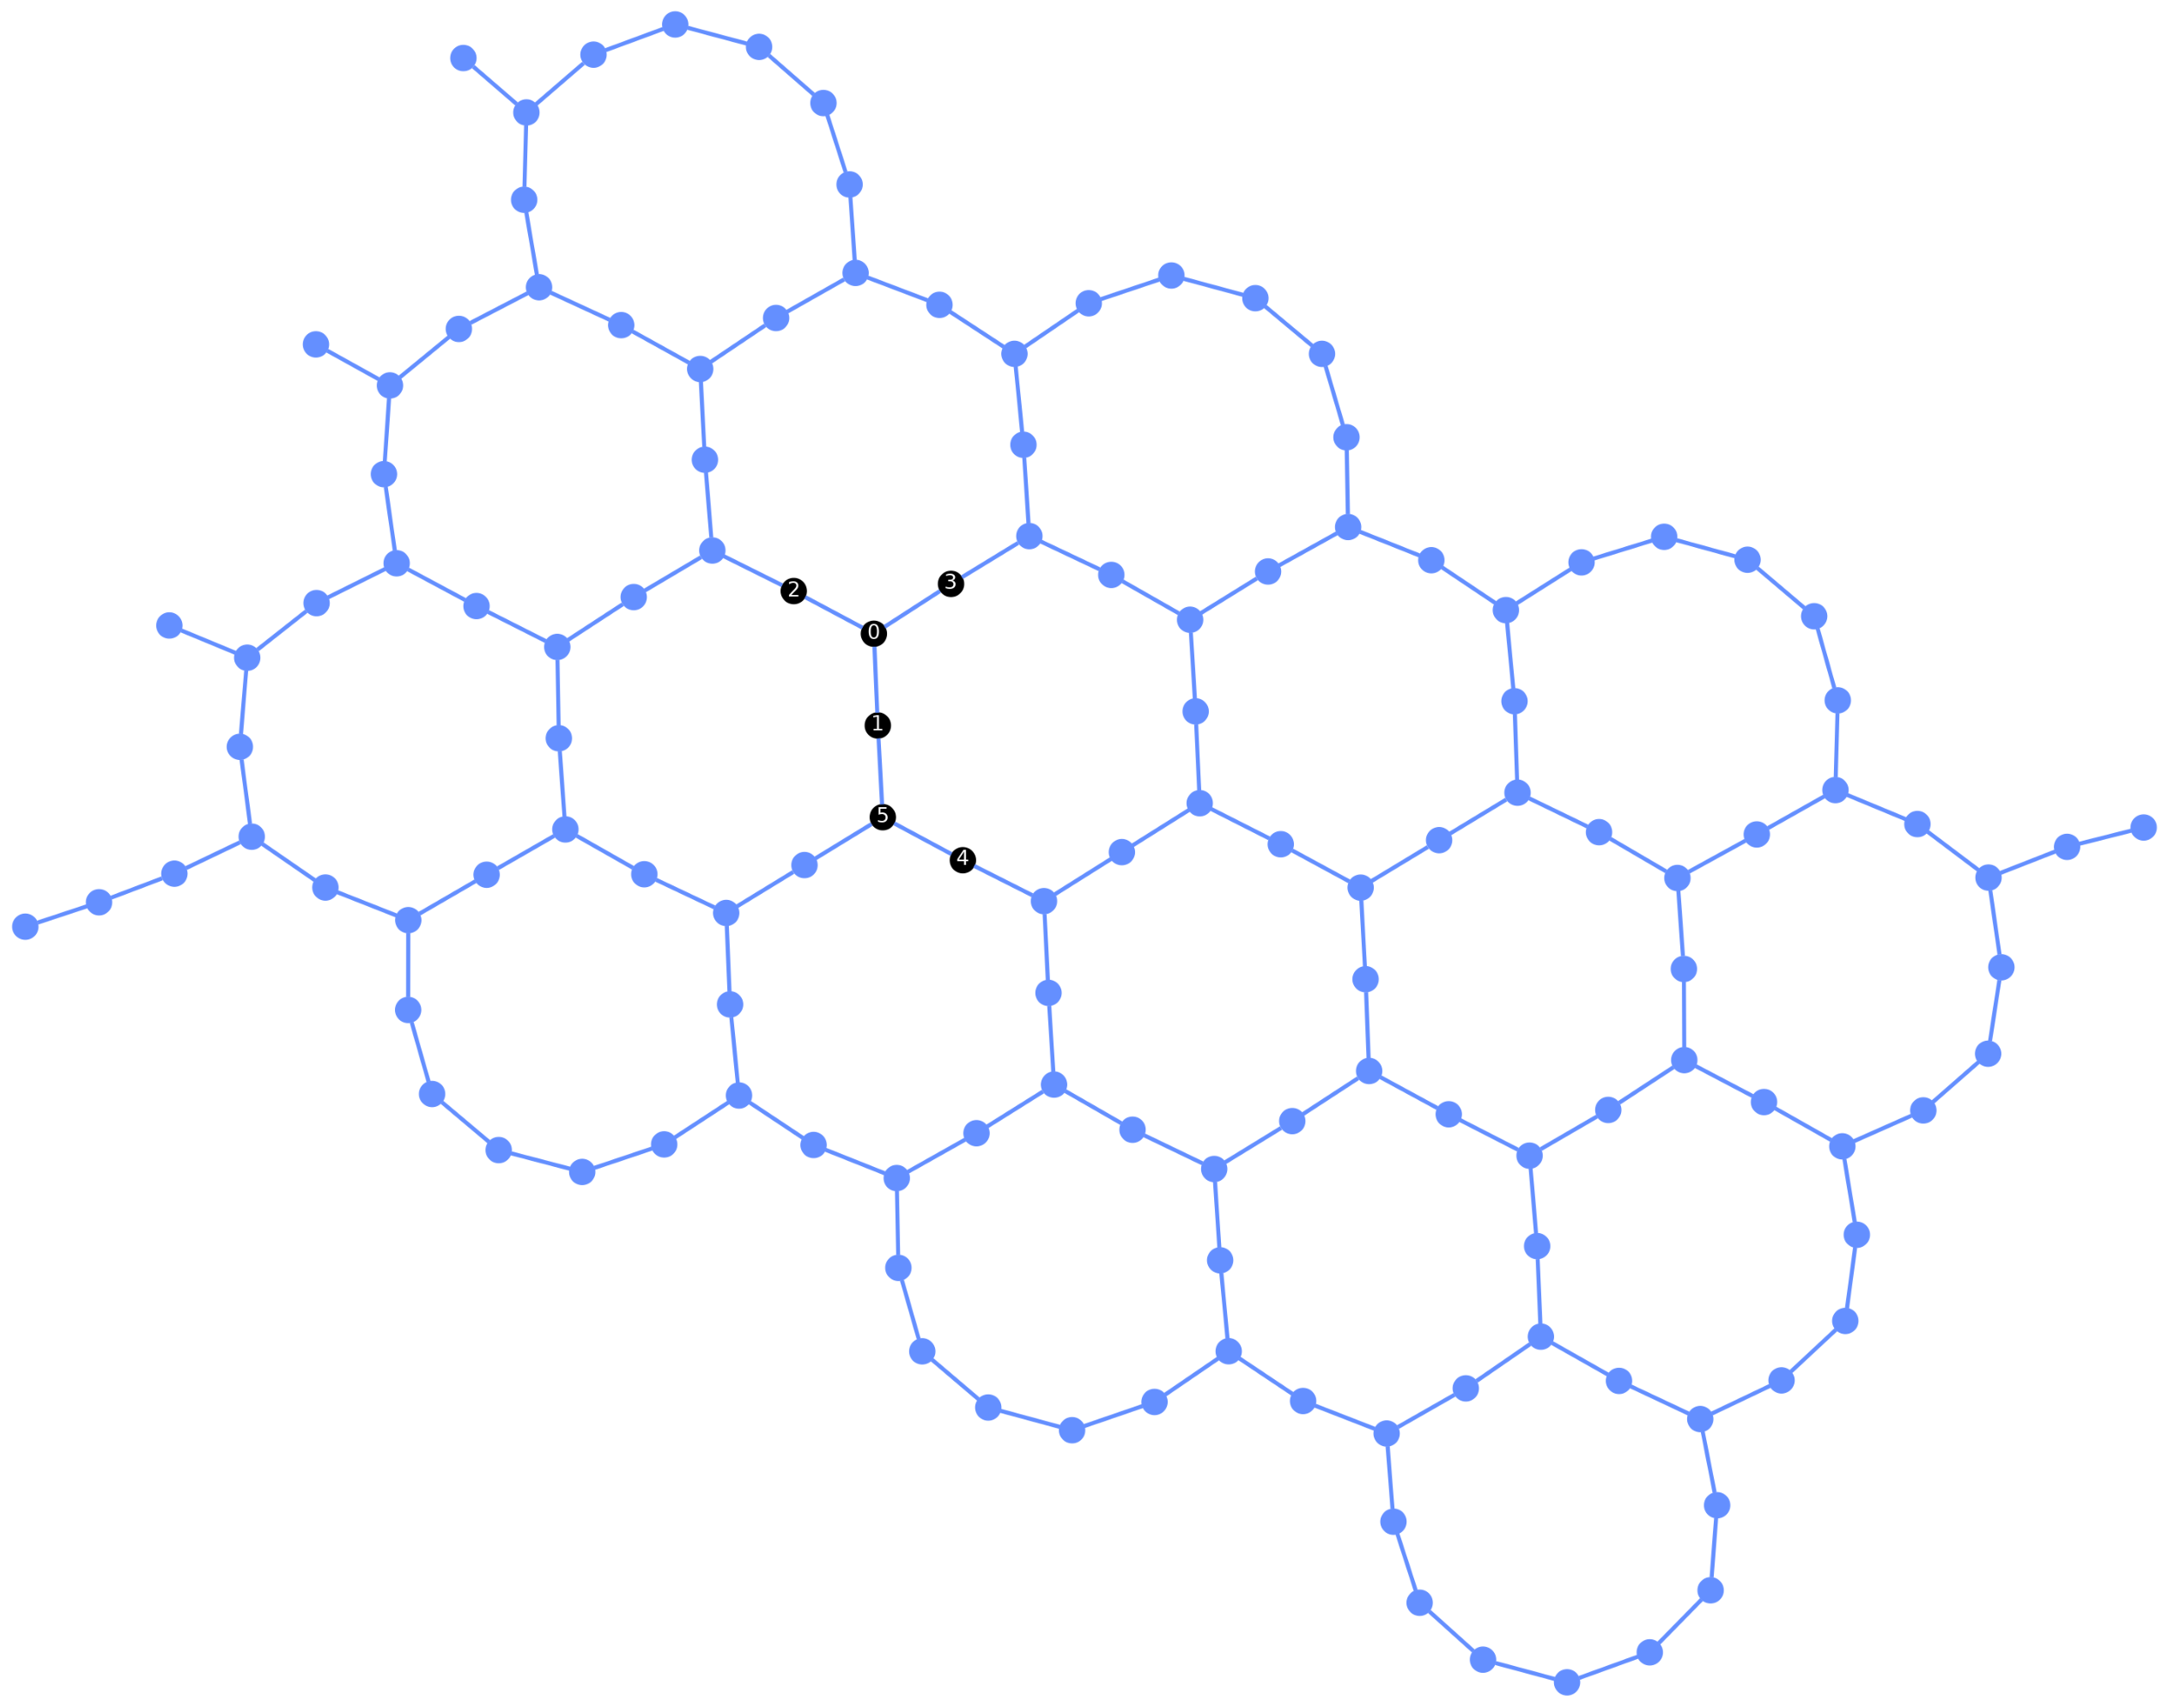


Optimization level 2:
 -  VF2Layout
 -  BarrierBeforeFinalMeasurements
 -  SabreLayout
 -  FlowControllerLinear
[85, 84, 83, 93, 73, 82]


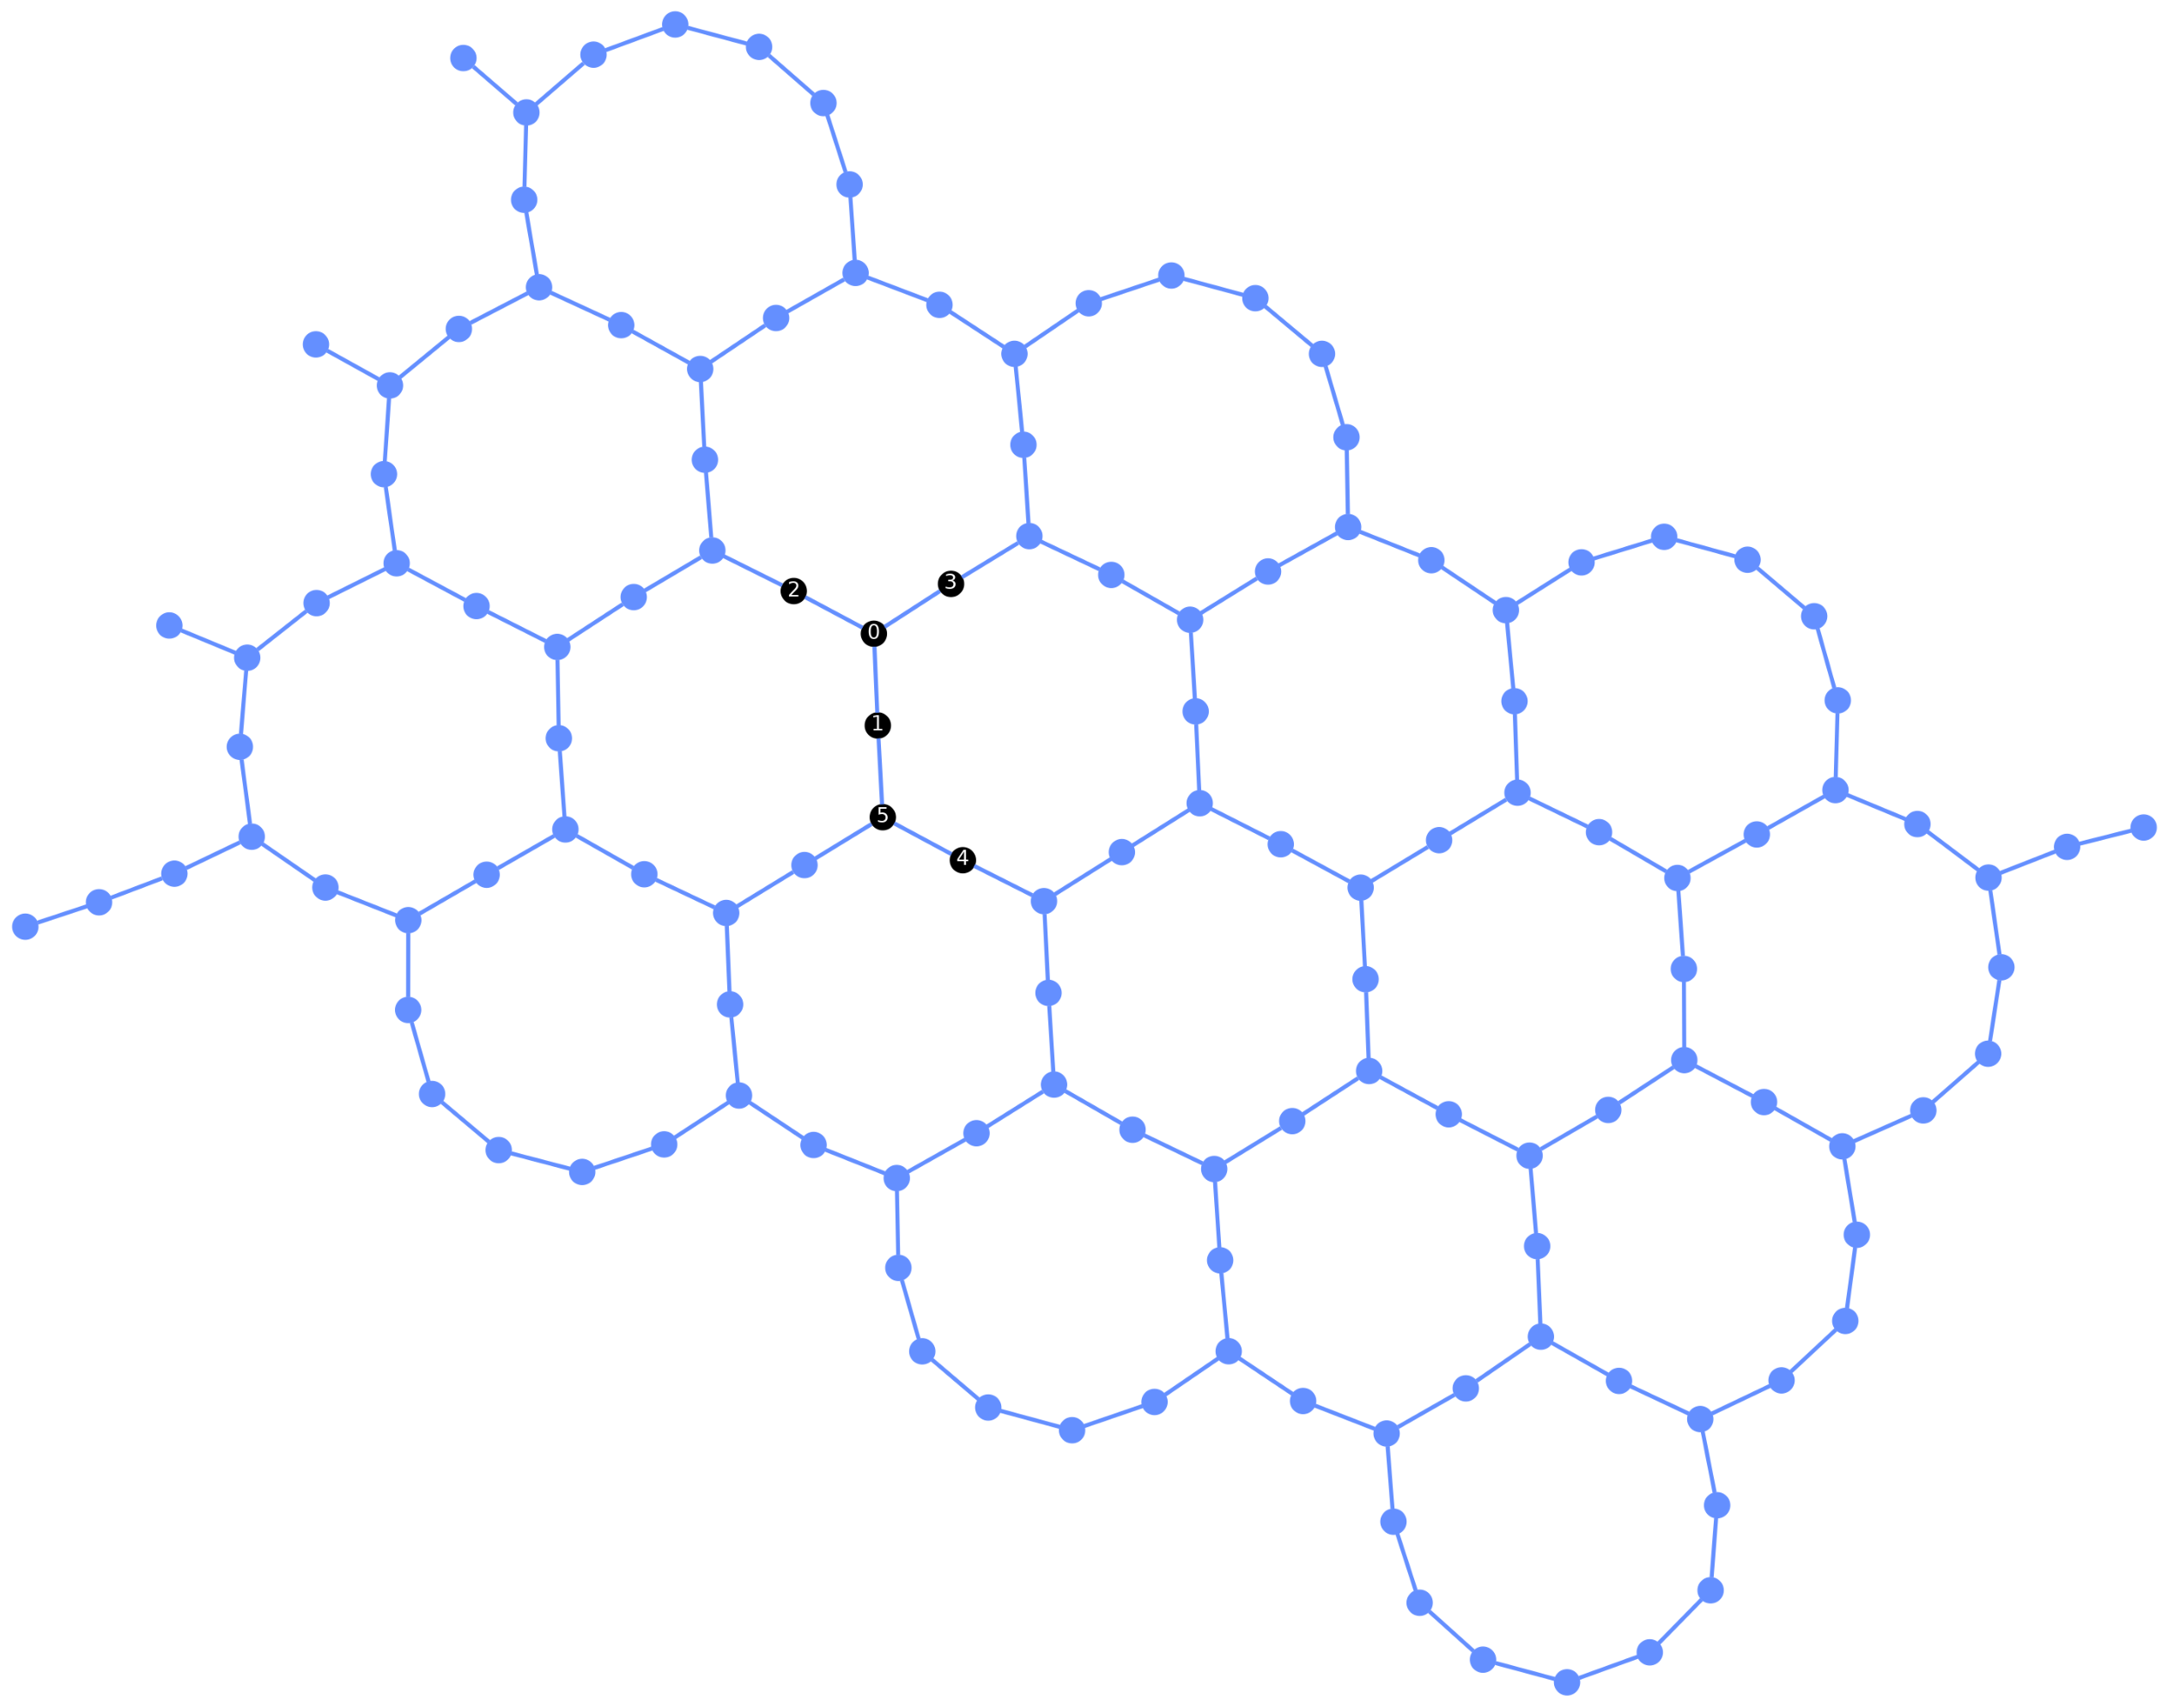


Optimization level 3:
 -  VF2Layout
 -  BarrierBeforeFinalMeasurements
 -  SabreLayout
 -  FlowControllerLinear
[85, 84, 83, 93, 73, 82]


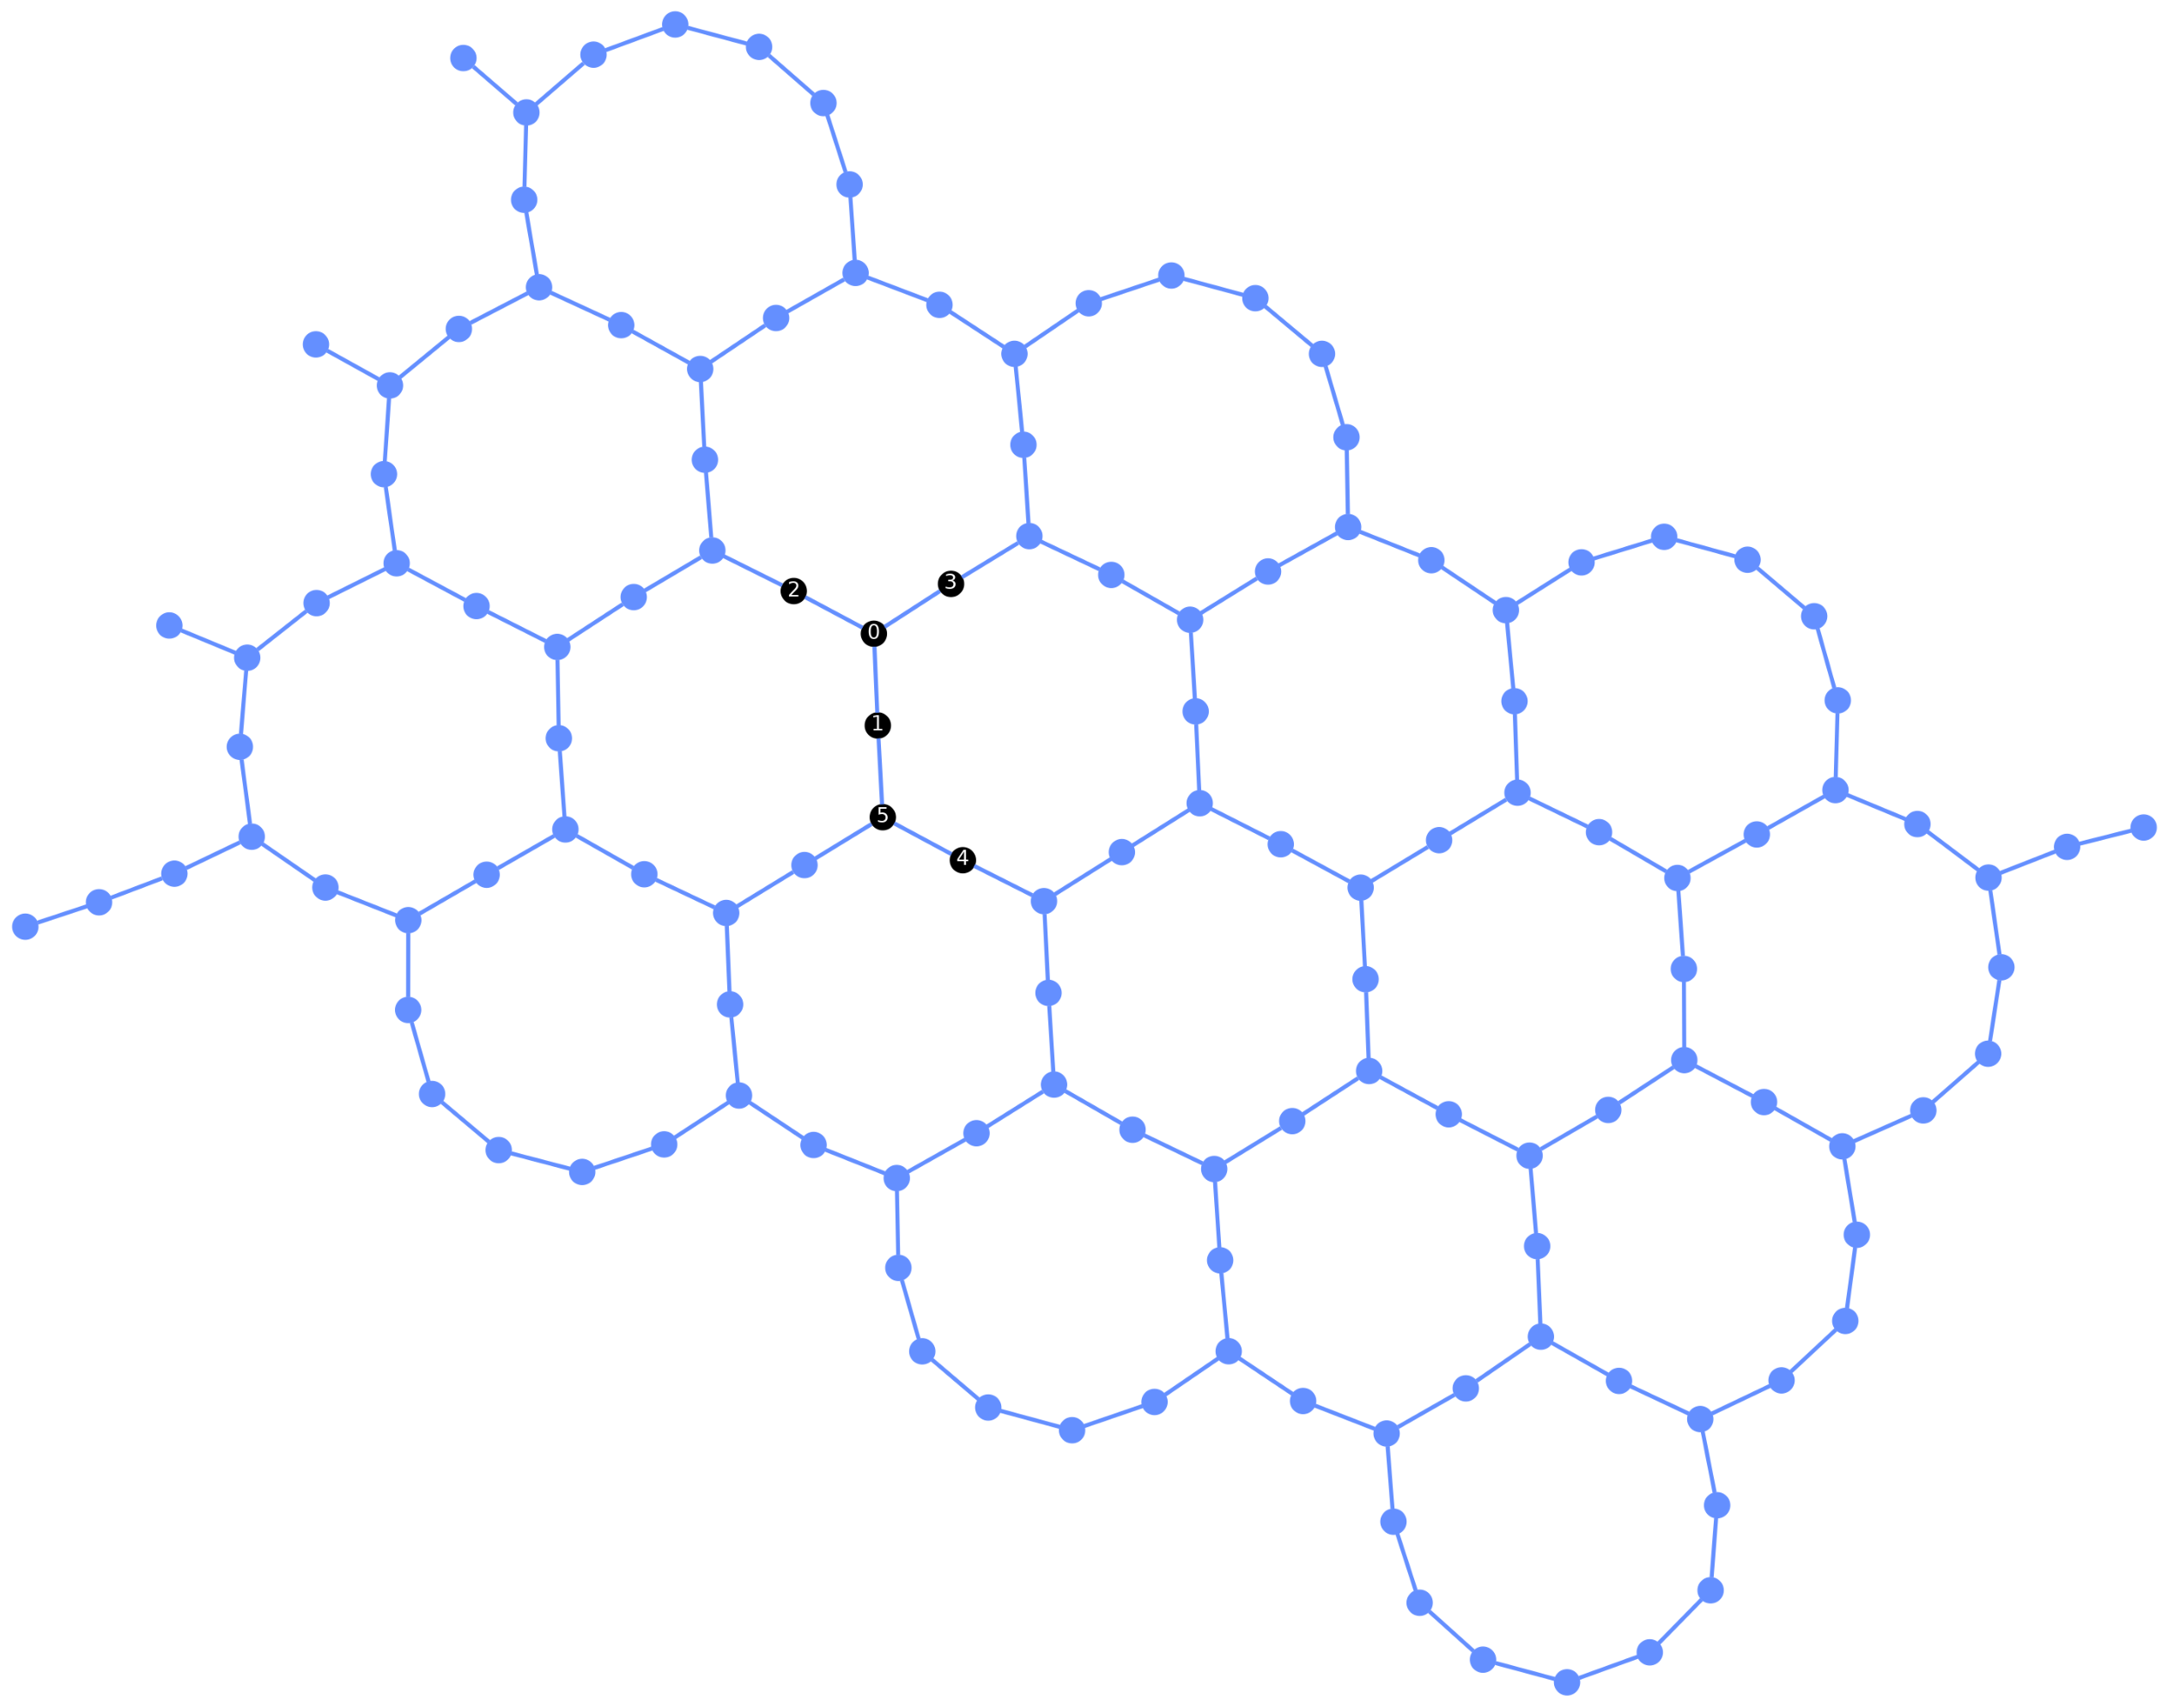

In [22]:
print("Plugins run by default layout stage")
print("=================================")
for i in range(4):
    print(f"\nOptimization level {i}:")
    pm = generate_preset_pass_manager(backend=backend, optimization_level=i, layout_method='default', seed_transpiler=seed)
    qc_tr = pm.run(qc)

    for controller_group in pm.layout.to_flow_controller().tasks:
        tasks = getattr(controller_group, "tasks", [])
        for task in tasks:
            print(" - " , str(type(task).__name__))
    print(qc_tr.layout.final_index_layout())
    display(plot_circuit_layout(pm.run(qc), backend))

では、 optimization_level=3 で各オプションのスコアとレイアウトを比較してみましょう。

In [26]:
for option in list_stage_plugins("layout"):
    pm = generate_preset_pass_manager(backend=backend, optimization_level=3, layout_method=option, seed_transpiler=seed)
    qc_tr = pm.run(qc)
    score = scoring(qc_tr, backend)

    print(f"Layout method = {option}")
    print(f"Score: {score:.6f}")
    print(f"Layout: {qc_tr.layout.final_index_layout()}\n")

Layout method = default
Score: 0.276088
Layout: [85, 84, 83, 93, 73, 82]

Layout method = dense
Score: 0.189147
Layout: [37, 52, 51, 49, 56, 50]

Layout method = sabre
Score: 0.276088
Layout: [85, 84, 83, 93, 73, 82]

Layout method = trivial
Score: 0.334350
Layout: [0, 1, 2, 4, 5, 3]



#### Routing ステージ

量子デバイス上で直接接続されていない量子ビット間の2量子ビットゲートを実装するためには、1つ以上のSWAPゲートを回路に挿入し、デバイスのゲートマップ上で隣接するまで量子ビットの状態を移動させる必要があります。それぞれのSWAPゲートは、実行するのにコストがかかり、ノイズの多い操作を表します。したがって、ある回路をあるデバイスにマッピングするのに必要なSWAPゲートの最小数を求めることは、トランスパイルプロセスにおける重要なステップとなります。効率化のため、このステージは通常、デフォルトで Layout ステージと並列で計算されますが、論理的には互いに異なります。 Layout ステージは使用するハードウェア量子ビットを選択し、Routing ステージは選択されたレイアウトを使用して回路を実行するために適切な数のSWAPゲートを挿入します。

しかし、最適なSWAPマッピングを見つけるのは困難です。実際、NP困難問題であるため、小さな量子デバイスや入力回路を除いて、計算コストが非常に高くなります。この問題を回避するために、Qiskit は SabreSwap と呼ばれる確率的ヒューリスティック アルゴリズムを使用して、必ずしも最適ではないが、良いSWAPマッピングを計算します。

確率的手法を使うということは、**生成される回路が繰り返し実行されても同じであることが保証されない**ということです。実際、同じ回路を繰り返し実行すると、出力における回路の深さとゲート数が分散します。このため、多くのユーザーはルーティング機能(または StagedPassManager 全体) を何度も実行し、出力の分散から最も深さの小さい回路を選択します。

In [27]:
list_stage_plugins("routing")

['basic', 'lookahead', 'none', 'sabre', 'stochastic']

In [28]:
print("Number of each gates of transpiled circuit and the score")
print("=================================")
for i in range(4):
    print(f"\nOptimization level {i}:")
    pm = generate_preset_pass_manager(backend=backend, optimization_level=i, routing_method='basic', seed_transpiler=seed)
    qc_tr = pm.run(qc)
    score = scoring(qc_tr, backend)
    for key, value in qc_tr.count_ops().items():
        print(key, ":", value)
    print(f"Score: {score:.6f}")

Number of each gates of transpiled circuit and the score

Optimization level 0:
rz : 406
sx : 192
cz : 81
x : 1
Score: 0.443191

Optimization level 1:
rz : 167
sx : 95
cz : 48
Score: 0.133092

Optimization level 2:
sx : 95
rz : 90
cz : 48
Score: 0.133092

Optimization level 3:
sx : 92
rz : 79
cz : 42
x : 1
Score: 0.121427


Plugins run by basic routing stage

Optimization level 0:
 -  BarrierBeforeFinalMeasurements
 -  BasicSwap


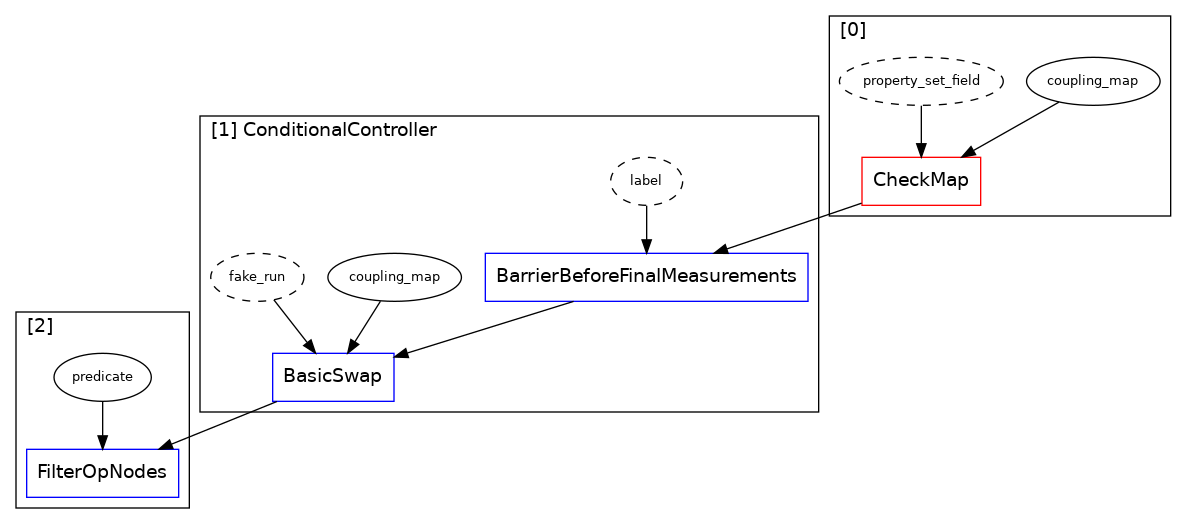

[4, 1, 2, 0, 5, 3]

Optimization level 1:
 -  BarrierBeforeFinalMeasurements
 -  BasicSwap
 -  VF2PostLayout
 -  ApplyLayout


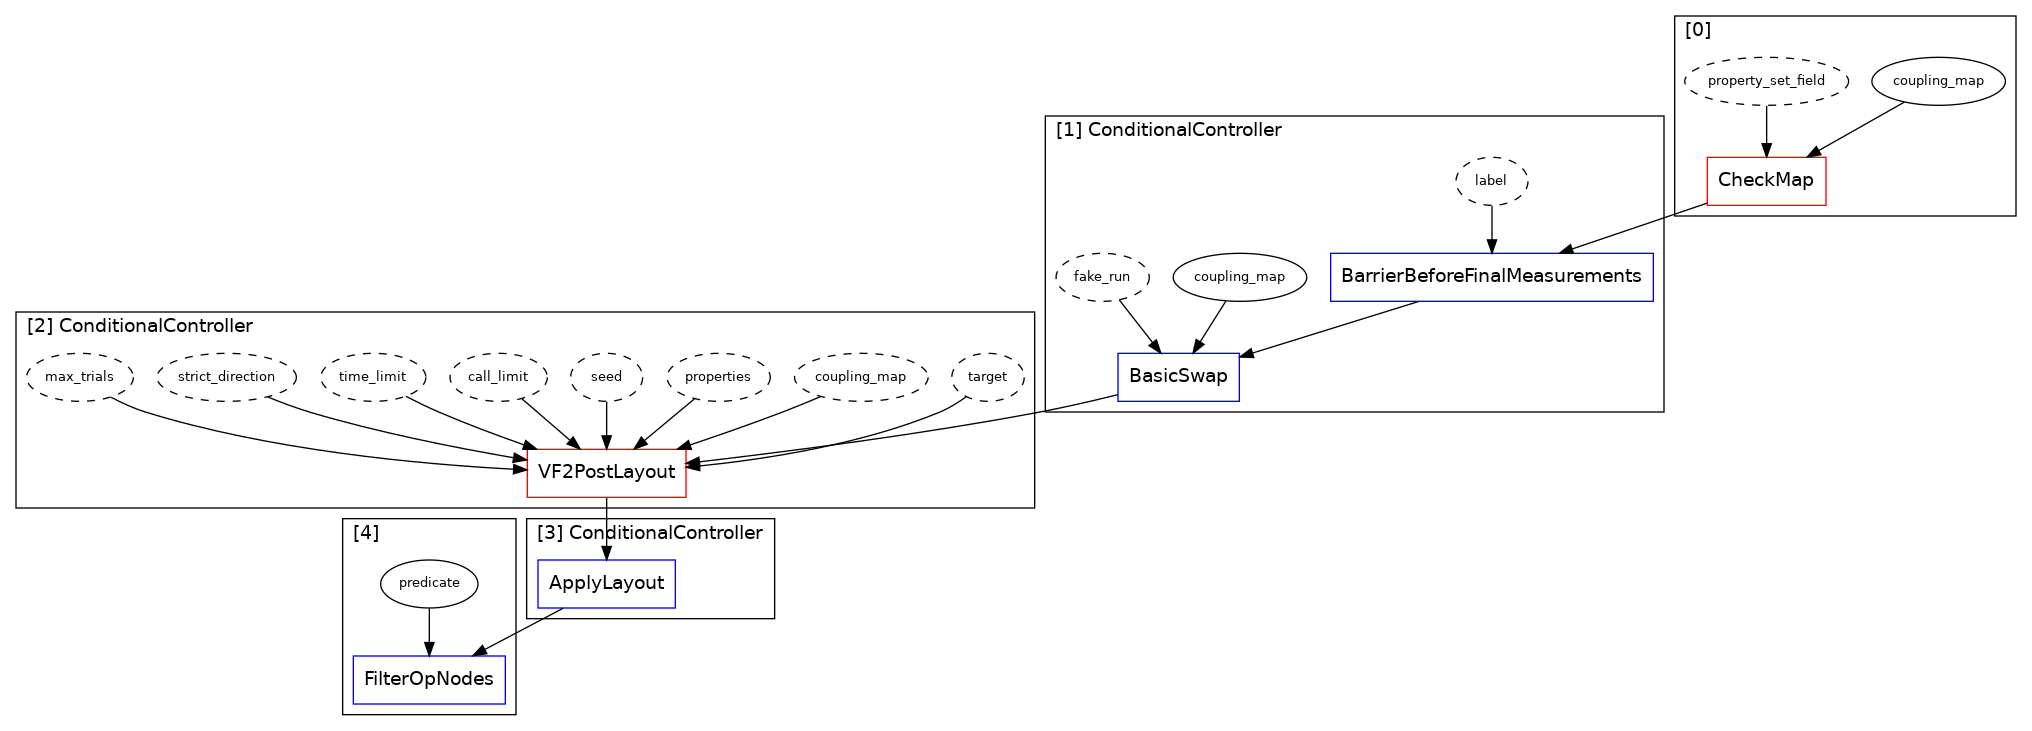

[99, 110, 97, 96, 92, 98]

Optimization level 2:
 -  BarrierBeforeFinalMeasurements
 -  BasicSwap
 -  VF2PostLayout
 -  ApplyLayout


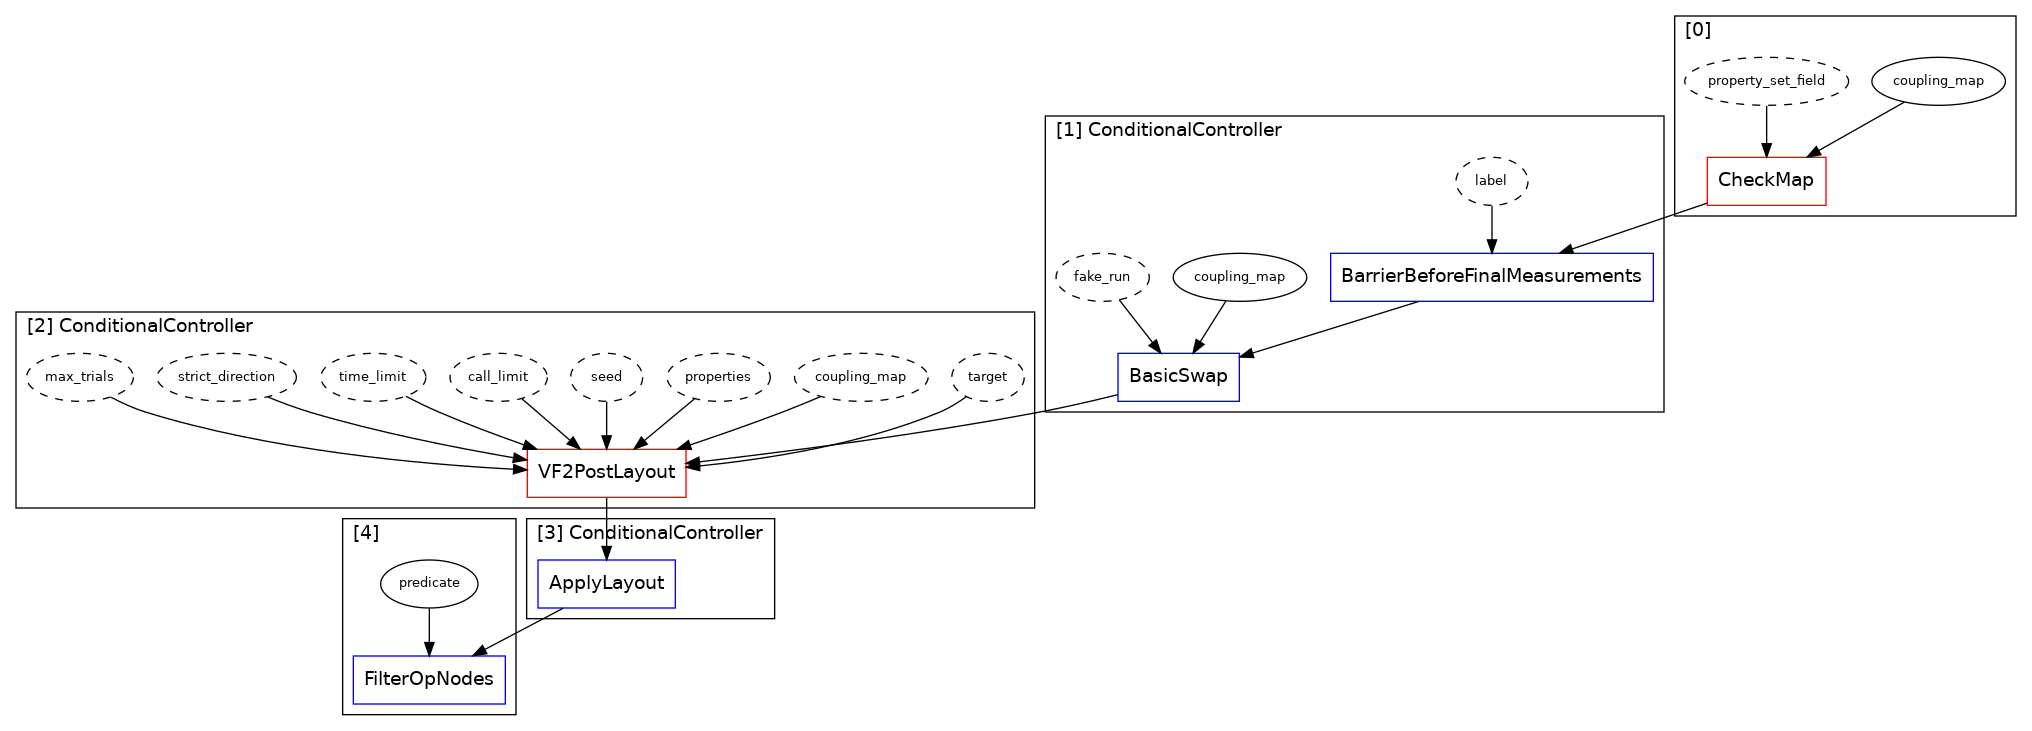

[99, 110, 97, 96, 92, 98]

Optimization level 3:
 -  BarrierBeforeFinalMeasurements
 -  BasicSwap
 -  VF2PostLayout
 -  ApplyLayout


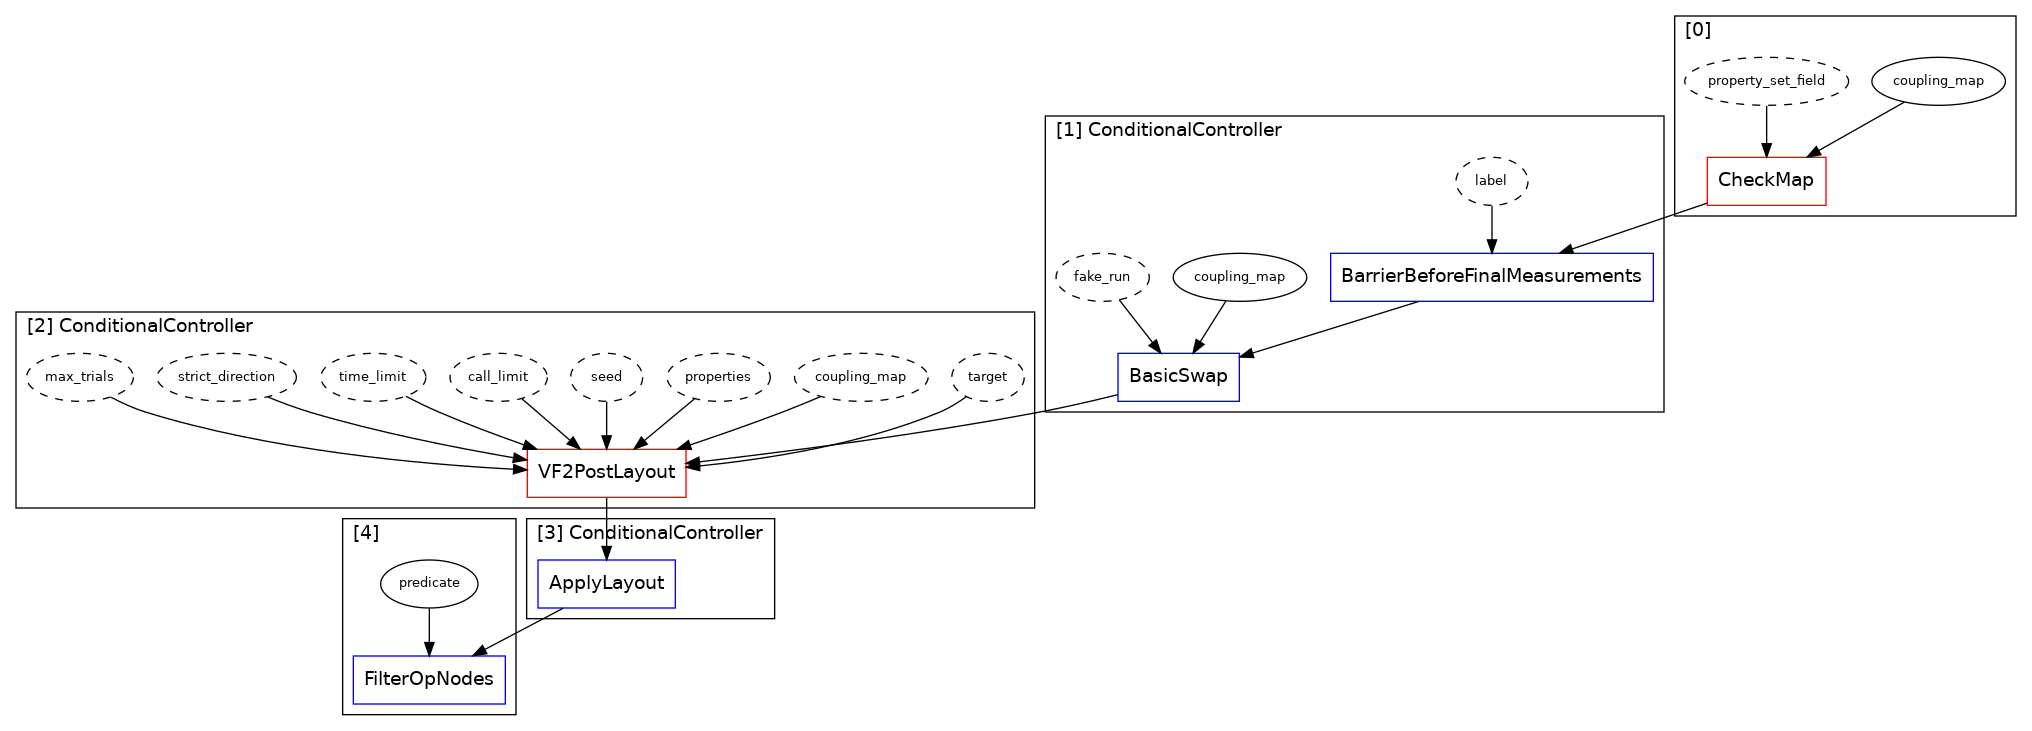

[99, 110, 97, 96, 92, 98]


In [29]:
print("Plugins run by basic routing stage")
print("=================================")
for i in range(4):
    print(f"\nOptimization level {i}:")
    pm = generate_preset_pass_manager(backend=backend, optimization_level=i, routing_method='basic', seed_transpiler=seed)

    for controller_group in pm.routing.to_flow_controller().tasks:
        tasks = getattr(controller_group, "tasks", [])
        for task in tasks:
            print(" - " , str(type(task).__name__))
    display(pm.routing.draw())
    print(pm.run(qc).layout.final_index_layout())

In [30]:
## process stopped due to lookahead
options = ['basic','sabre', 'stochastic']

for option in options:
    print(f"Layout option = {option}:")
    pm = generate_preset_pass_manager(backend=backend, optimization_level=3, routing_method=option, seed_transpiler=seed)
    qc_tr = pm.run(qc)
    score = scoring(qc_tr, backend)

    print(f"Score: {score:.6f}")

    for key, value in qc_tr.count_ops().items():
        print(key, ":", value)
    print("\n")

Layout option = basic:
Score: 0.121427
sx : 92
rz : 79
cz : 42
x : 1


Layout option = sabre:
Score: 0.096126
sx : 74
rz : 65
cz : 37
x : 1


Layout option = stochastic:
Score: 0.169540
sx : 137
rz : 108
cz : 66




#### Translation ステージ


量子回路を書く際には、量子ゲート（ユニタリー演算）を自由に使うことができ、量子ビットの測定やリセット命令などの非ゲート演算も自由に使うことができます。しかし、ほとんどの量子デバイスが、ネイティブでサポートしている量子ゲートと非ゲート演算はほんの一握りです。これらのネイティブ・ゲートはターゲットの ISA の定義の一部であり、preset PassManagers のこのステージでは、回路で指定されたゲートを指定されたバックエンドがネイティブに利用できるゲートに Translation（または展開）します。これは回路をバックエンドで実行できるようにするための重要なステップですが、通常、ゲートの深さと数の増加につながります。

2 つの特殊なケースを強調することは特に重要であり、このステージで何が行われるかを説明するのに役立ちます。

1. SWAPゲートがターゲット・バックエンドのネイティブ・ゲートでない場合、3つのCNOTゲートが必要です。： 3つのCNOTゲートの積である、SWAPはノイズの多い量子デバイス上で実行するにはコストのかかる操作です。しかし、このような演算は、通常多くのデバイスの限られたゲート接続性の中に回路を埋め込むために必要です。従って、回路中のSWAPゲートの数を最小限に抑えることが、トランスパイルプロセスにおける主な目標です。

![](./resources/2024-spring-lab2-swap-cnot.png)

2. トフォリゲート、または制御制御 NOT ゲート (ccx) は、3 量子ビット ゲートです。基本ゲートセットには1量子ビットゲートと2量子ビットゲートのみが含まれているため、この演算は分解する必要があります。量子回路のトフォリゲート1つに対して、ハードウェアは最大6つのCNOTゲートと少数の1量子ビット・ゲートを実行する可能性があります。この例は、複数のトフォリゲートを使用するアルゴリズムは、最終的に回路Depthが大きくなり、ノイズの影響を大きく受けることを示しています。

![](./resources/2024-spring-lab2-toffoli-cnot.png)

```{note}
[2020年のChallenge](https://quantum-tokyo.github.io/ibm-quantum-challenge-textbook/2020-w1-a-adder-ja.html)でToffoliゲートの分解について扱っているので併せて参照してください。
```

どれだけのオプションが使えるか確認してみましょう。

In [31]:
list_stage_plugins("translation")

['ibm_backend',
 'ibm_dynamic_circuits',
 'synthesis',
 'translator',
 'ibm_backend',
 'ibm_dynamic_circuits']

Qiskit の基本オプションは 'translator' と 'synthesis' です。デフォルトのオプション ('translator') と各optimization levelでトランスパイルされた回路の総ゲート数、回路Depth、スコアを数えてみましょう。

In [32]:
print("Number of each gates of transpiled circuit")
print("=================================")

for i in range(4):
    print(f"\nOptimization level {i}:")
    pm = generate_preset_pass_manager(backend=backend, optimization_level=i, translation_method='translator', seed_transpiler=seed)
    qc_tr = pm.run(qc)
    score = scoring(qc_tr, backend)
    for key, value in qc_tr.count_ops().items():
        print(key, ":", value)
    print(f"Score: {score:.6f}")

Number of each gates of transpiled circuit

Optimization level 0:
rz : 394
sx : 186
cz : 78
x : 1
Score: 0.378009

Optimization level 1:
rz : 131
sx : 77
cz : 39
Score: 0.100534

Optimization level 2:
sx : 77
rz : 71
cz : 39
Score: 0.100534

Optimization level 3:
sx : 74
rz : 65
cz : 37
x : 1
Score: 0.096126


各オプションとoptimization_level=3での総ゲート数、回路Depth 、トランスパイル回路のスコアを数えてみましょう。

In [33]:
options = ['translator', 'synthesis']

print("Number of each gates of transpiled circuit")
print("=================================")

for option in options:
    print(f"Layout option = {option}:")
    pm = generate_preset_pass_manager(backend=backend, optimization_level=3, translation_method=option, seed_transpiler=seed)
    qc_tr = pm.run(qc)
    score = scoring(qc_tr, backend)
    for key, value in qc_tr.count_ops().items():
        print(key, ":", value)
    print(f"Score: {score:.6f}")
    print("\n")

Number of each gates of transpiled circuit
Layout option = translator:
sx : 74
rz : 65
cz : 37
x : 1
Score: 0.096126


Layout option = synthesis:
sx : 73
rz : 70
cz : 37
x : 12
Score: 0.099269




グラフにプロットしてみましょう。

In [34]:
tr_depths = []
tr_gate_counts = []
tr_scores = []

options = ['translator', 'synthesis']

for i in range(4):
    for option in options:
        pm = generate_preset_pass_manager(backend=backend, optimization_level=i, translation_method=option, seed_transpiler=seed)

        tr_depths.append(pm.run(qc).depth())
        tr_gate_counts.append(sum(pm.run(qc).count_ops().values()))
        tr_scores.append(scoring(pm.run(qc), backend))

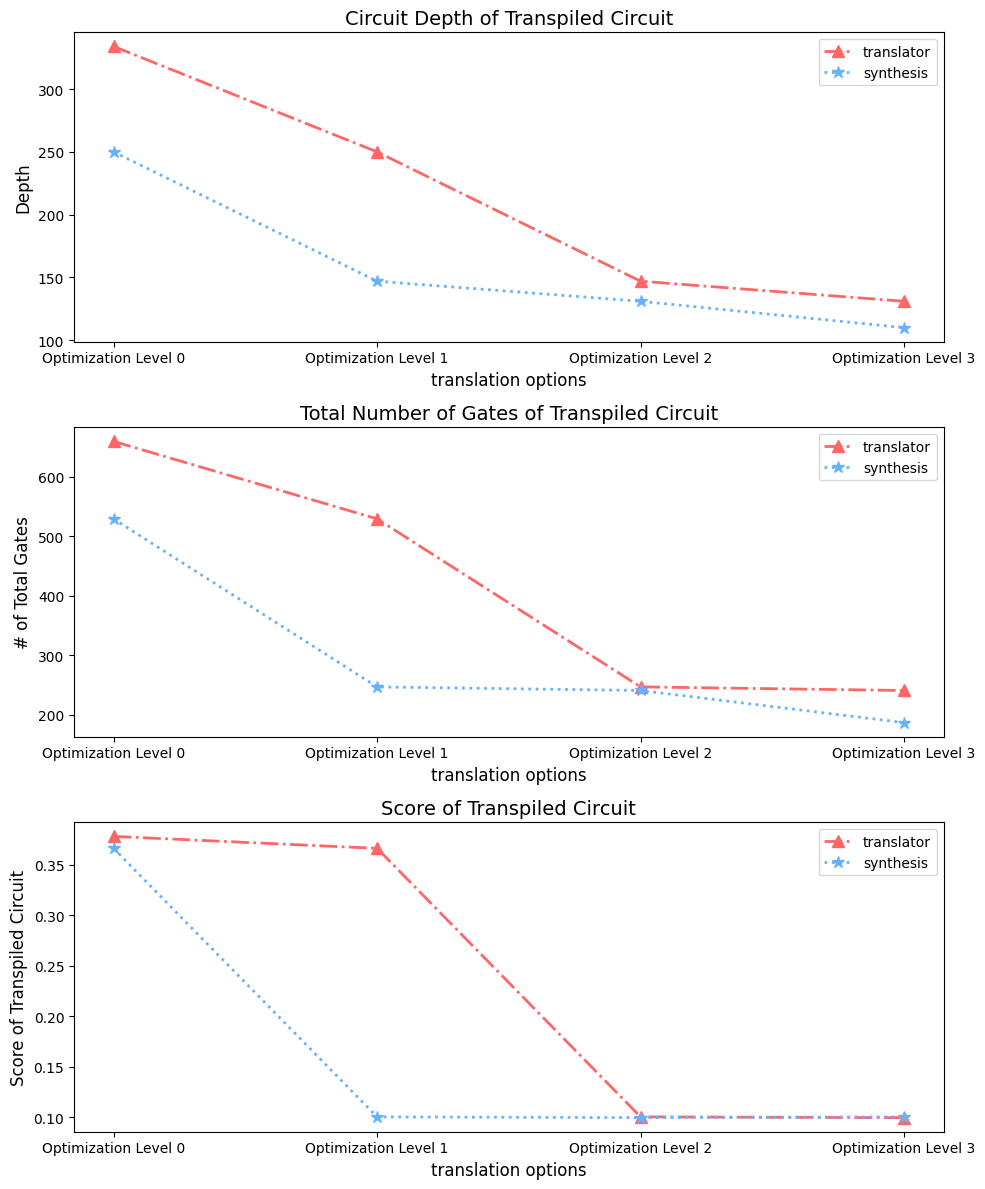

In [35]:
colors = ['#FF6666', '#66B2FF']
markers = [ '^', '*']
linestyles = ['-.', ':']

opt_list = []
for i in range(4):
    opt_list.append(f"Optimization Level {i}")

ax = opt_list
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

# Plot 1: Circuit Depth
for i in range(2):
    ax1.plot(ax, tr_depths[i:i+4], label=options[i], marker=markers[i], markersize=9, linestyle=linestyles[i], color=colors[i], linewidth=2)
ax1.set_xlabel("translation options", fontsize=12)
ax1.set_ylabel("Depth", fontsize=12)
ax1.set_title("Circuit Depth of Transpiled Circuit", fontsize=14)
ax1.legend(fontsize=10)

# Plot 2: Total Number of Gates
for i in range(2):
    ax2.plot(ax, tr_gate_counts[i:i+4], label=options[i], marker=markers[i], markersize=9, linestyle=linestyles[i], color=colors[i], linewidth=2)
ax2.set_xlabel("translation options", fontsize=12)
ax2.set_ylabel("# of Total Gates", fontsize=12)
ax2.set_title("Total Number of Gates of Transpiled Circuit", fontsize=14)
ax2.legend(fontsize=10)

# Plot 3: Score of Transpiled Circuit
for i in range(2):
    ax3.plot(ax, tr_scores[i:i+4], label=options[i], marker=markers[i],markersize=9, linestyle=linestyles[i], color=colors[i], linewidth=2)
ax3.set_xlabel("translation options", fontsize=12)
ax3.set_ylabel("Score of Transpiled Circuit", fontsize=12)
ax3.set_title("Score of Transpiled Circuit", fontsize=14)
ax3.legend(fontsize=10)

fig.tight_layout()
plt.show()

#### Optimization ステージ


量子回路をターゲット・デバイスの基本ゲート・セットに分解し、ハードウェア・トポロジーと一致させるために Swap ゲートを追加すると、量子回路の深さとゲート数が増大します。幸いなことに、ゲートの結合や削除によって回路を最適化するルーチンが数多く存在します。場合によっては、これらの方法は非常に効果的であり、出力回路は入力回路よりも深さが浅くなります。また、他の場合には、できることがほとんどなく、ノイズの多いデバイスでは計算が困難な場合もあります。異なるゲートの最適化は、異なるoptimization_level値でオンになります。

- optimization_level=1 の場合、このステージは [Optimize1qGatesDecomposition](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.Optimize1qGatesDecomposition) と [CXCancellation](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.CXCancellation) を準備し、単一量子ビット・ゲートのチェーンを結合し、連続する CNOT ゲートをキャンセルします。
- optimization_level=2の場合、このステージでは `CXCancellation` の代わりに [CommutativeCancellation](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.CommutativeCancellation) パスを使用し、交換関係を利用して冗長ゲートを削除します。
- optimization_level=3の場合、このステージは以下のパスを準備します：[Collect2qBlocks](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.Collect2qBlocks), [ConsolidateBlocks](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.ConsolidateBlocks), [UnitarySynthesis](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.UnitarySynthesis), [Optimize1qGateDecomposition](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.Optimize1qGatesDecomposition), [CommutativeCancellation](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.CommutativeCancellation)。さらに、このステージでは、回路内のすべての命令がターゲットのバックエンドで利用可能な基本ゲートで構成されていることを確認するために、いくつかの最終チェックも実行します。

このステージでは、2つのオプションを設定できます：

- approximation_degree (float, in the range 0-1 | None) - 回路近似に使われるヒューリスティック・ダイヤル（1.0 = 近似なし、0.0 = 最大近似）。デフォルト値は1.0。None を指定すると、近似度が報告されたエラー・レートに設定されます。詳細については、近似度のセクションを参照してください。
- optimization_method (str) - Optimization ステージで使用するプラグイン名。デフォルトでは、外部プラグインは使用されません。引数 stage_name に optimization を指定して list_stage_plugins() を実行すると、インストールされているプラグインの一覧を見ることができます。


#### Bonus exercise

````{admonition} Exercise
このステージは、回路のゲートを最適化することに強く関係しているので、各optimization_levelごとに以下のプロットをしてみよう。

1. 総ゲート数
2. 回路の深さ
3. トランスパイルされた回路のスコア

approximation_degree 値 $[ 0, 0.1, 0.2, ... ,0.9, 1]$ を変えて、以下のコードを書いてみましょう。

```python
tr_depths = []
tr_gate_counts = []
tr_scores = []

approximation_degree_list = np.linspace(0,1,10)

for i in range(4):
    for j in approximation_degree_list:
        # your code here #


        # your code here #
```
````

In [ ]:
tr_depths = []
tr_gate_counts = []
tr_scores = []

approximation_degree_list = np.linspace(0,1,10)

for i in range(4):
    for j in approximation_degree_list:
        # your code here #
        pm = generate_preset_pass_manager(backend=backend, optimization_level=i, approximation_degree=j, seed_transpiler=seed) 
        tr_qc = pm.run(qc)
        tr_depths.append(tr_qc.depth())
        tr_gate_counts.append(sum(tr_qc.count_ops().values()))
        tr_scores.append(scoring(tr_qc, backend))
        # your code here #

In [ ]:
colors = ['#FF6666', '#FFCC66', '#99FF99', '#66B2FF']
markers = ['o', 's', '^', '*']
linestyles = ['-', '--', '-.', ':']

ax = approximation_degree_list
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12))

# Plot 1: Circuit Depth
for i in range(4):
    ax1.plot(ax, tr_depths[i::4], label=f"Optimization Level {i}", marker=markers[i], markersize=9, linestyle=linestyles[i], color=colors[i], linewidth=2)
ax1.set_xlabel("Approximation Degree", fontsize=12)
ax1.set_ylabel("Depth", fontsize=12)
ax1.set_title("Circuit Depth of Transpiled Circuit", fontsize=14)
ax1.legend(fontsize=10)

# Plot 2: Total Number of Gates
for i in range(4):
    ax2.plot(ax, tr_gate_counts[i::4], label=f"Optimization Level {i}", marker=markers[i], markersize=9, linestyle=linestyles[i], color=colors[i], linewidth=2)
ax2.set_xlabel("Approximation Degree", fontsize=12)
ax2.set_ylabel("# of Total Gates", fontsize=12)
ax2.set_title("Total Number of Gates of Transpiled Circuit", fontsize=14)
ax2.legend(fontsize=10)

# Plot 3: Score of Transpiled Circuit
for i in range(4):
    ax3.plot(ax, tr_scores[i::4], label=f"Optimization Level {i}", marker=markers[i],markersize=9, linestyle=linestyles[i], color=colors[i], linewidth=2)
ax3.set_xlabel("Approximation Degree", fontsize=12)
ax3.set_ylabel("Score of Transpiled Circuit", fontsize=12)
ax3.set_title("Score of Transpiled Circuit", fontsize=14)
ax3.legend(fontsize=10)

fig.tight_layout()
plt.show()

#### Scheduling ステージ

この最後のステージは（initステージと同様に）、明示的に呼び出された場合にのみ実行され、デフォルトでは実行されません（ただし、 `generate_preset_pass_manager` を呼び出すときに 1scheduling_method1 引数を設定することでメソッドを指定できます）。Scheduling ステージは通常、回路がターゲットの基本ゲートに変換され、デバイスにマッピングされ、最適化された後に使用されます。これらのpassは、回路内のすべてのアイドル時間を考慮することに重点を置いています。高いレベルでは、scheduling passは、ゲート実行間のアイドル時間を考慮し、回路がバックエンドで実行される時間を検査するために、明示的に遅延命令を挿入すると考えることができます。

まず、どのオプションが使えるかを確認しましょう。

In [ ]:
list_stage_plugins("scheduling")

スケジューリング・オプションを使うために、まず、最適化されたパルス・スケジュールを得るために、バックエンドの関連情報を含む `timing_constraints`を用意しましょう。

In [ ]:
backend_timing = backend.target.timing_constraints()
timing_constraints = TimingConstraints(
    granularity=backend_timing.granularity,
    min_length=backend_timing.min_length,
    pulse_alignment=backend_timing.pulse_alignment,
    acquire_alignment=backend_timing.acquire_alignment )

In [ ]:
# Run with optimization level 3 and 'asap' scheduling pass
pm_asap = generate_preset_pass_manager(
    optimization_level=3,
    backend=backend,
    timing_constraints=timing_constraints,
    scheduling_method="asap",
    seed_transpiler=seed,
)

In [ ]:
my_style = {
    'formatter.general.fig_width': 40,
    'formatter.general.fig_unit_height': 1,
}

draw(pm_asap.run(qc), style=IQXStandard(**my_style), show_idle=False, show_delays=True)

In [ ]:
pm_alap = generate_preset_pass_manager(
    optimization_level=3,
    backend=backend,
    timing_constraints=timing_constraints,
    scheduling_method="alap",
    seed_transpiler=seed,
)
draw(pm_alap.run(qc), style=IQXStandard(**my_style), show_idle=False, show_delays=True)

ご覧のように、これら2つの回路は多くの遅延がありますが、位置と順序が異なります。回路とバックエンドによって、このスケジューリングは性能の違いが生じる可能性があります。この2つの回路のスコアをチェックして比較してみましょう。

In [ ]:
print("Score")
print("===============")
print(f"asap: {scoring(pm_asap.run(qc), backend):.6f}")
print(f"alap: {scoring(pm_alap.run(qc), backend):.6f}")

````{admonition} Exercise 4
**あなたのタスク：** この時点で、あなたは様々なパスマネージャーを作るプロになった気分になっているはずです。以下のオプションでpass managersを作ってください：

1. optimization level = 3
2. "sabre" layout
3. "sabre" routing
4. "synthesis" translation

```python
pm_ex4 = generate_preset_pass_manager(
    backend=backend,

    ### Write your code below here ###



    ### Don't change any code past this line ###
)
```
````

In [ ]:
pm_ex4 = generate_preset_pass_manager(
    backend=backend,

    ### Write your code below here ###



    ### Don't change any code past this line ###
)

### staged pass managerで独自のpass managersを構築する <a name='staged_pm'></a>

Qiskit v1.0 transpiler の強力な特徴の1つは、その柔軟性です。2つか3つのステージだけで `PassManager` を構成することができます。また、任意のステージに独自の `Pass` を配置することもできます。

#### `Dynamical Decoupling` passの構築


ここでは、 `Dynamical Decoupling` (動的デカップリング) を実行するための custom `scheduling` pass を構築してみます。Dynamical decoupling は、アイドル状態の量子ビットにパルス シーケンス（Dynamical decoupling シーケンスとして知られている）を追加してブロッホ球の周りを反転させ、ノイズチャネルの影響をキャンセルし、デコヒーレンスを抑制します。これらのパルスシーケンスは、核磁気共鳴で使われるリフォーカスパルスに似ています。詳しい説明は、 [A Quantum Engineer's Guide to Superconducting Qubits](https://arxiv.org/abs/1904.06560) を参照してください。さらに詳しく知りたい方は、[Qiskit video](https://www.youtube.com/watch?v=67jRWQuW3Fk) で Nick Bronn が Dynamic decoupling について説明しています。


詳細については、 [dynamical decouplingのためのpass managerを作成する](https://docs.quantum.ibm.com/transpile/dynamical-decoupling-pass-manager) ドキュメントをご覧ください。

引き続き同じ量子回路を使用します。Dynamical decoupling シーケンスとは、アイデンティティを構成する一連のゲートで、時間的に規則的な間隔があります。例えば、4つのゲートからなる XY4 という単純なシーケンスを作成することから始めます。

In [ ]:
X = XGate()
Y = YGate()

dd_sequence = [X, Y, X, Y]

Dynamical decouplingシーケンスのタイミングが規則的であるため、YGate に関する情報をターゲットに追加する必要があります。これは、XGate が basis gate であるのに対し、YGate は basis gate ではないためです。だし、YGate の持続時間とエラーは XGate と同じであることが事前にわかっているため、ターゲットからそれらのプロパティを取得して、YGate に追加し直すことができます。これも basis_gates が別に保存されている理由です。YGate 命令をターゲットに追加していますが、これは ibm_torino バックエンド（ここでは FakeTorino ですが、本物の ibm_torino の basis gate セットを含む同じコンフィギュレーションを持っています）の実際の basis gate ではないからです。

In [ ]:
backend=FakeTorino()

target = backend.target

y_gate_properties = {}
for qubit in range(target.num_qubits):
    y_gate_properties.update(
        {
            (qubit,): InstructionProperties(
                duration=target["x"][(qubit,)].duration,
                error=target["x"][(qubit,)].error,
            )
        }
    )

target.add_instruction(YGate(), y_gate_properties)

次に、カスタムの passesを実行します。

````{admonition} Exercise 5
**あなたのタスク：** `ASAPScheduleAnalysis` と `PadDynamicalDecoupling` を使用して PassManager をインスタンス化します。`ASAPScheduleAnalysis` を最初に実行し、量子回路のタイミング情報を追加してから、規則的な間隔の dynamical decoupling シーケンスを追加します。これらのpassは、.run()を使用して回路上で実行されます。
```python
dd_pm = PassManager(
    [
        ## your code here

        ## your code here

    ]
)
```
````

In [ ]:
dd_pm = PassManager(
    [
        ## your code here

        ## your code here

    ]
)

では、 `asap` スケジューリングオプションの`Timing` と比較しながら、どのように機能するかを見てみみましょう。まず、上記のタイミング図を見てみましょう。

In [ ]:
draw(pm_asap.run(qc), style=IQXStandard(**my_style), show_idle=False, show_delays=True)

では、作成した関数を使って、 custom scheduling `Pass` を作ってみましょう。

この新しい `scheduling pass` には `StagedPassManager` を使います。passが1つしかないPassManagerを作ることができます。カスタムstaged PassManagerを作ったら、これを上で作成した pm_asap でトランスパイルされた回路に適用します。


In [ ]:
staged_pm_dd = StagedPassManager(
    stages=["scheduling"],
    scheduling=dd_pm
)

In [ ]:
qc_tr = pm_asap.run(qc)
draw(staged_pm_dd.run(qc_tr), style=IQXStandard(**my_style), show_idle=False, show_delays=True)

## (ボーナス) エコシステムと Qiskit Transpiler プラグイン

Qiskitユーザーのコミュニティーによるカスタムなトランスパイルコードの開発と再利用を促進するため、Qiskit SDK はサードパーティーのPython パッケージが Qiskit 経由でアクセス可能な拡張トランスパイル機能を提供することを宣言できるプラグイン・インターフェースをサポートしています。

現在、サードパーティーのプラグインは3つの方法で拡張トランスパイル機能を提供することができます：

- [A transpiler stage plugin](https://docs.quantum.ibm.com/api/qiskit/transpiler_plugins) は preset staged pass manager の6つのステージ（init、layout、routing、translation、optimization、scheduling）のうちの1つの代わりに使用できるpass managerを提供します。
- [A unitary synthesis plugin](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.synthesis.plugin.UnitarySynthesisPlugin) は、ユニタリゲート合成のための拡張機能を提供します。
- [A high-level synthesis plugin](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.synthesis.plugin.HighLevelSynthesisPlugin) は、線形関数やクリフォード演算子などの「ハイレベル・オブジェクト」を合成するための拡張機能を提供します。ハイレベル・オブジェクトは、[Operation](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.Operation) クラスのサブクラスで表現されます。

プラグインのインストール方法や使用方法などの詳細については、 [このページ](https://docs.quantum.ibm.com/transpile/transpiler-plugins) を参照してください。

また、これらのプラグインの `contributor` になることもできます！トランスパイラー・プラグインを作成することは、あなたのトランスパイルコードをより広い Qiskit コミュニティーと共有する素晴らしい方法で、他のユーザーが開発した機能の恩恵を受けることができます。[ここ](https://docs.quantum.ibm.com/transpile/create-a-transpiler-plugin) には、素敵なトランスパイラー・プラグインを提供することで Qiskit コミュニティに貢献するためのガイドラインと手順が記載されています。

## 追加情報

**Created by:** Sophy Shin, Sumit Suresh Kale, Abby Cross

**Advised by:** Va Barbosa, Junye Huang, Brian Ingmanson

**Translated by:** Kifumi Numata

**Version:** 1.0.0